<h1 align="center">Building Machine Learning Classifiers for Water Quality</h1> 
<h2 align="center">Amrit Sandhir</h2> 

### I: Background
### II: Exploratory Data Analysis
### III. Data Preprocessing 
### IV: Model Selection and Evaluation
### V: Conclusion

## I: Background

Safe, clean water is key to any society's public hygeine and overall health.  Whether for consumption, food production, or cleaning, water is a resource that is essential to life and survival.  Unfortunately many people don't have access to safe water, which results in higher infection, disease, and death rates.  According to a WHO/UNICEF 2021 report, 771 million people (~9.75% of the world's population) do not have access to clean water near their homes.  The World Bank states that promoting good hygiene is one of the most cost-effective health interventions.

It is important to understand what factors, chemicals, and substances in water can determine whether it is safe to use or not.  If analysis and machine learning models can identify what chemical factors contribute to unsafe water, initiatives can be taken to limit the occurance of such substances/chemicals and increase overall global health.   To that end, a dataset of water quality containing 7,999 instances was obtained (https://www.kaggle.com/mssmartypants/water-quality).  Each instance contained 20 chemical/substance variable numeric markers and whether the water was deemed safe (1) or not (0).   

This analysis will review the characateristics of the underlying data, implement various classification machine learning models to predict the outcome variable (safe or not safe), and determine the 'goodness' of the models thru  various evaluation metrics.  The aim is to build a series of models that can generalize well and predict water quality on data 'unseen' in either the model building or testing phases.

#### Note: if you do not have imbalanced-learn package already installed and you want to replicate results, you will need to install the package:


In [1]:
#pip install -U imbalanced-learn

#### Importing the various modules and settings for the analysis

In [2]:
import pandas as pd
pd.get_option("display.max_columns")
import numpy as np
import scipy.stats as stats
from io import StringIO
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.colors as mcolors 
sns.set_context('notebook')
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, roc_curve, roc_auc_score)


from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline as imblnc_make_pipeline
from collections import Counter

<h1 align="center">Data Dictionary</h1> 

| Column      | Description       | Data Type     | Example | Min Value | Max Value
| :---       |     :----         |         :--- |  :----      | :---- | :----
| aluminium |  dangerous if greater than 2.8 | float64 | 1.65 | 0.0 | 5.05 |
| ammonia |  dangerous if greater than 32.5 | float64 | 9.08 | -0.08 | 29.84 |
| arsenic |  dangerous if greater than 0.01 | float64 | 0.04 | 0.0 | 1.05 |
| barium |  dangerous if greater than 2 | float64 | 2.85 | 0.0 | 4.94 |
| cadmium |  dangerous if greater than 0.005 | float64 | 0.007 | 0.0 | 0.13 |
| chloramine |  dangerous if greater than 4 | float64 | 0.35 | 0.0 | 8.68 |
| chromium |  dangerous if greater than 0.1 | float64 | 0.83 | 0.0 | 0.9 |
| copper |  dangerous if greater than 1.3 | float64 | 0.17 | 0.0 | 2.0 |
| flouride |  dangerous if greater than 1.5 | float64 | 0.05 | 0.0 | 1.5 |
| bacteria |  dangerous if greater than 0 | float64 | 0.2 | 0.0 | 1.0 |
| viruses |  dangerous if greater than 0 | float64 | 0.0 | 0.0 | 1.0 |
| lead |  dangerous if greater than 0.015 | float64 | 0.054 | 0.0 | 0.2 |
| nitrates |  dangerous if greater than 10 | float64 | 16.08 | 0.0 | 19.83 |
| nitrites |  dangerous if greater than 1 | float64 | 1.13 | 0.0 | 2.93 |
| mercury |  dangerous if greater than 0.002 | float64 | 0.007 | 0.0 | 0.01 |
| perchlorate |  dangerous if greater than 56 | float64 | 37.75 | 0.0 | 60.01 |
| radium |  dangerous if greater than 5 | float64 | 6.78 | 0.0 | 7.99 |
| selenium |  dangerous if greater than 0.5 | float64 | 0.08 | 0.0 | 0.1 |
| silver |  dangerous if greater than 0.1 | float64 | 0.34 | 0.0 | 0.5 |
| uranium |  dangerous if greater than 0.3 | float64 | 0.02 | 0.0 | 0.09 |
| is_safe | 0-not safe, 1-safe | float64 | 1.0 | 0.0 | 1.0 |

### II: Exploratory Data Analysis

In [3]:
water_qlty_df=pd.read_csv(r'waterQuality1.csv', na_values='#NUM!')
water_qlty_df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1.0
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1.0
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0.0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1.0
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1.0


In [4]:
print('\n'+'\033[1m'+'The water quality dataset has {:d} records and {:d} columns'\
      .format(water_qlty_df.shape[0], water_qlty_df.shape[1]))


The water quality dataset has 7999 records and 21 columns


In [5]:
water_qlty_df.isna().sum()

aluminium      0
ammonia        3
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        3
dtype: int64

In [6]:
water_qlty_df.dtypes

aluminium      float64
ammonia        float64
arsenic        float64
barium         float64
cadmium        float64
chloramine     float64
chromium       float64
copper         float64
flouride       float64
bacteria       float64
viruses        float64
lead           float64
nitrates       float64
nitrites       float64
mercury        float64
perchlorate    float64
radium         float64
selenium       float64
silver         float64
uranium        float64
is_safe        float64
dtype: object

In [7]:
water_qlty_df[water_qlty_df['ammonia'].isna()]

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7551,0.03,NaN,0.08,0.79,0.07,0.08,0.05,0.58,0.34,0.00,...,0.183,4.37,1.43,0.007,0.62,2.54,0.07,0.05,0.05,NaN
7568,0.06,NaN,0.07,1.72,0.08,0.32,0.01,1.11,0.61,0.00,...,0.178,12.10,2.03,0.008,1.37,2.05,0.06,0.10,0.07,NaN
7890,0.01,NaN,0.08,0.49,0.00,0.07,0.09,0.06,0.72,0.57,...,0.088,9.57,1.45,0.009,7.67,7.70,0.03,0.05,0.02,NaN


In [8]:
#split the water quality frame into safe and unsafe frames for further EDA
safe_df=water_qlty_df[water_qlty_df.is_safe==1].iloc[:, :-1]

unsafe_df=water_qlty_df[water_qlty_df.is_safe==0].iloc[:, :-1]

In [9]:
#are variables normally distributed in each class

sf_nrm_p_values=pd.DataFrame()
sf_nrm_p_values['pval_nrml_dist']=safe_df.apply(lambda x: stats.normaltest(np.random.choice(x, size=500), 
                                                                           nan_policy='omit')[1])
unsf_nrm_p_values=pd.DataFrame()
unsf_nrm_p_values['pval_nrml_dist']=unsafe_df.apply(lambda x: stats.normaltest(np.random.choice(x, size=500), 
                                                                               nan_policy='omit')[1])


#percentage of outlier variable values in each class
# x< 0.25 - 1.5*IQR
# x> 0.75 + 1.5*IQR
sf_outlier_df=pd.DataFrame()
sf_outlier_df['perc_outlier']=safe_df.apply(lambda x: 100*sum(np.logical_or(x<(np.quantile(x, 0.25)-1.5*stats.iqr(x)),
                                                                        x>np.quantile(x, 0.75)+1.5*stats.iqr(x)))\
                                            /len(safe_df))

unsf_outlier_df=pd.DataFrame()
unsf_outlier_df['perc_outlier']=unsafe_df.apply(lambda x: 100*sum(np.logical_or(x<(np.quantile(x, 0.25)-1.5*stats.iqr(x)),
                                                                        x>np.quantile(x, 0.75)+1.5*stats.iqr(x)))\
                                            /len(unsafe_df))

In [10]:
a_df=pd.concat([round(unsafe_df.describe(),2).T[['mean','50%', 'std']], 
                pd.Series(round(unsafe_df.skew(),2), name='skew'), 
                round(unsf_nrm_p_values,2), round(unsf_outlier_df,2)], axis=1)

iterables = [['UnSafe'], a_df.columns]

array=pd.MultiIndex.from_product(iterables, names=['Class', 'Stats'])

a_df.columns=array

           
b_df=pd.concat([round(safe_df.describe(),2).T[['mean','50%', 'std']], 
                pd.Series(round(safe_df.skew(),2), name='skew'), 
                round(sf_nrm_p_values,2),
                round(sf_outlier_df,2)], axis=1)


iterables = [['Safe'], b_df.columns]

array=pd.MultiIndex.from_product(iterables, names=['Class', 'Stats'])

b_df.columns=array

print('\n', '\033[1m'+'Safe vs. Unsafe Water: Statistical Measures of Numerical Variables'+'\033[1m', '\n' )
pd.concat([b_df, a_df],axis=1).sort_values(('Safe', 'mean'), ascending=False).style.background_gradient(cmap='flare')



 Safe vs. Unsafe Water: Statistical Measures of Numerical Variables 



In [11]:
np.random.seed(42)

p_value_lst=[]
alpha=0.05
for i in water_qlty_df.columns[:-1]:
    obs_stat, p_value=stats.ttest_ind(np.random.choice(safe_df[i], size=100),
                                      np.random.choice(unsafe_df[i], size=100))
    p_value_lst.append(round(p_value,4))
    
    if p_value<alpha:
        print('At a {:.3f} p-value, we can reject the assumption the {:s} mean value between safe\n'\
          'and unsafe drinking water are the same at the {:.2f} level of significance\n'.format(p_value, i, alpha))

p_value_df=pd.Series(data=p_value_lst, index=water_qlty_df.columns[:-1]).to_frame('p_value')

At a 0.000 p-value, we can reject the assumption the aluminium mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.001 p-value, we can reject the assumption the arsenic mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.003 p-value, we can reject the assumption the barium mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.000 p-value, we can reject the assumption the cadmium mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.002 p-value, we can reject the assumption the chloramine mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.011 p-value, we can reject the assumption the chromium mean value between safe
and unsafe drinking water are the same at the 0.05 level of significance

At a 0.021 p-value, we can reject the ass

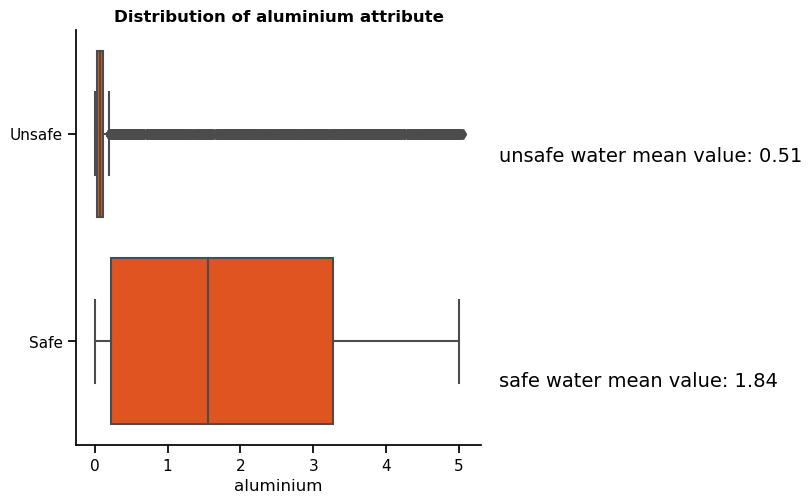

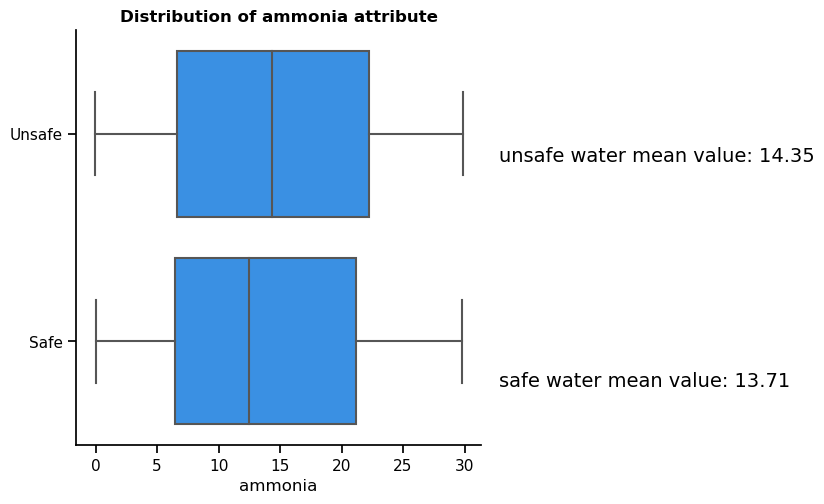

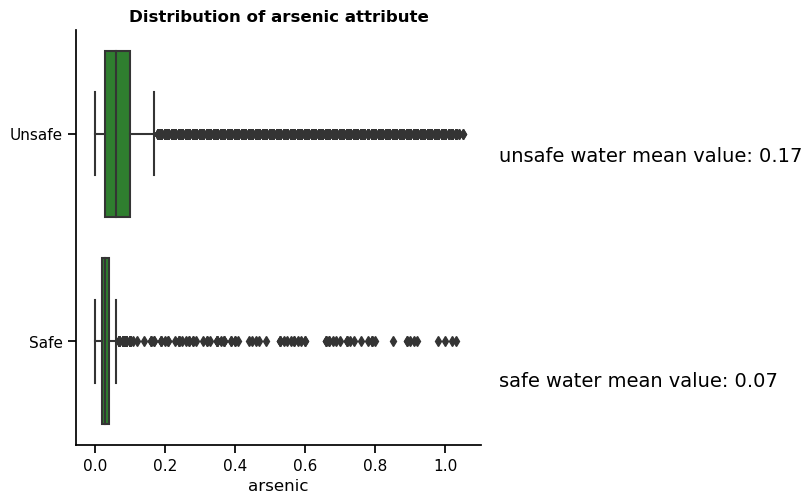

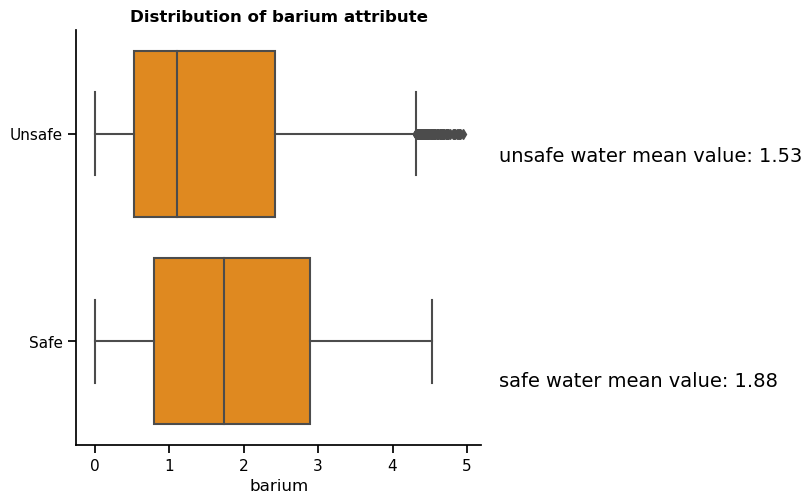

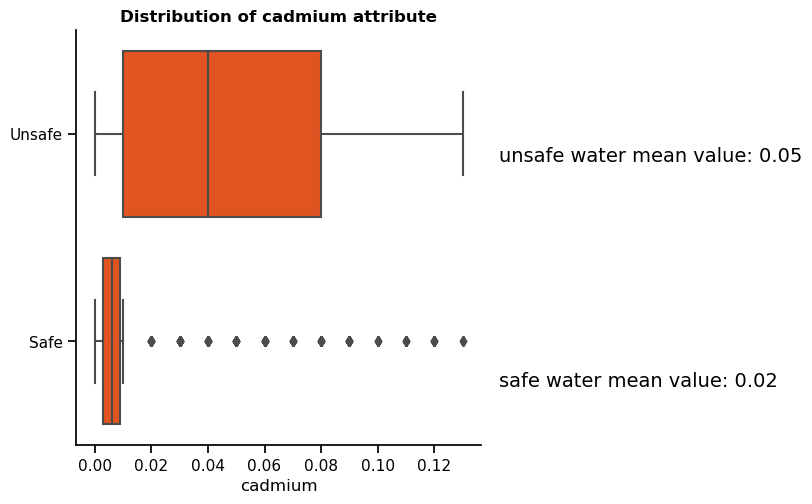

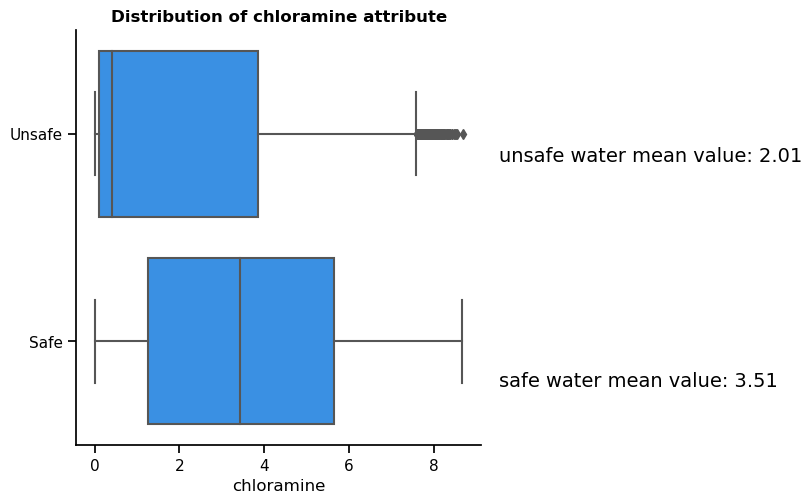

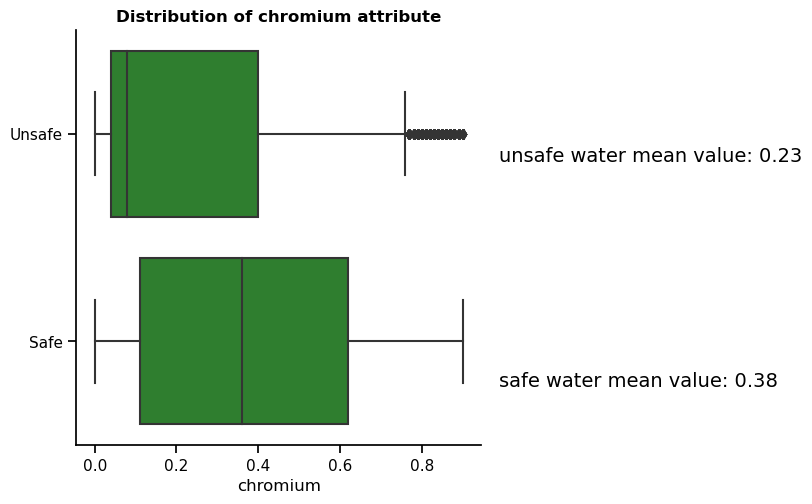

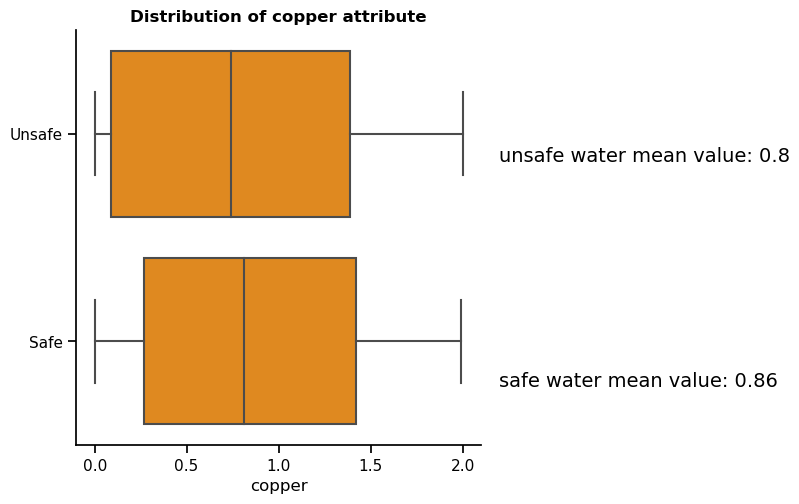

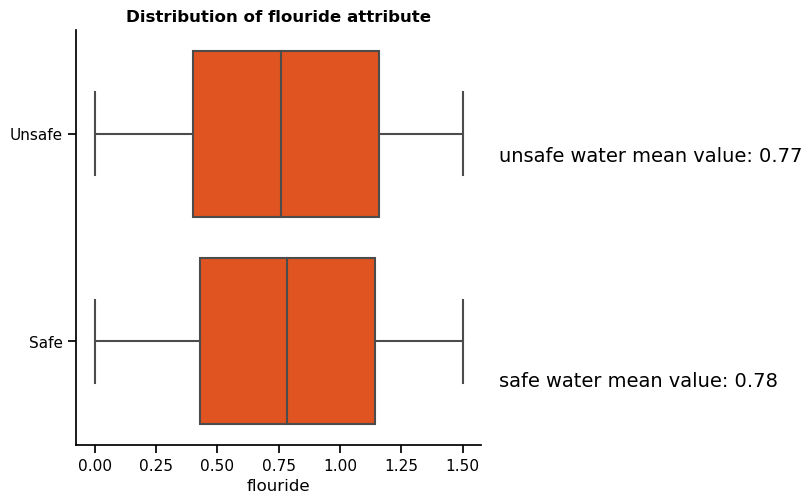

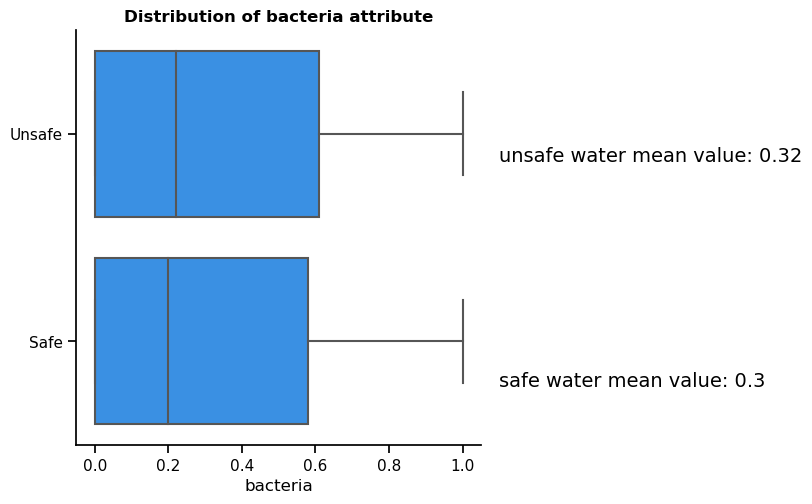

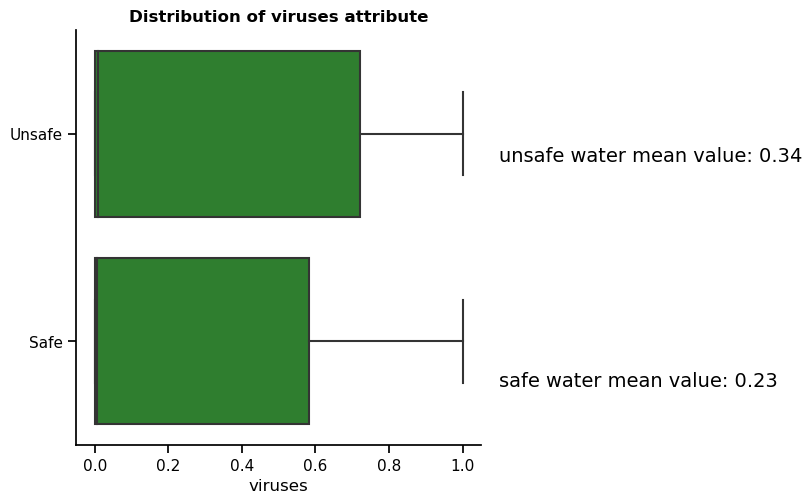

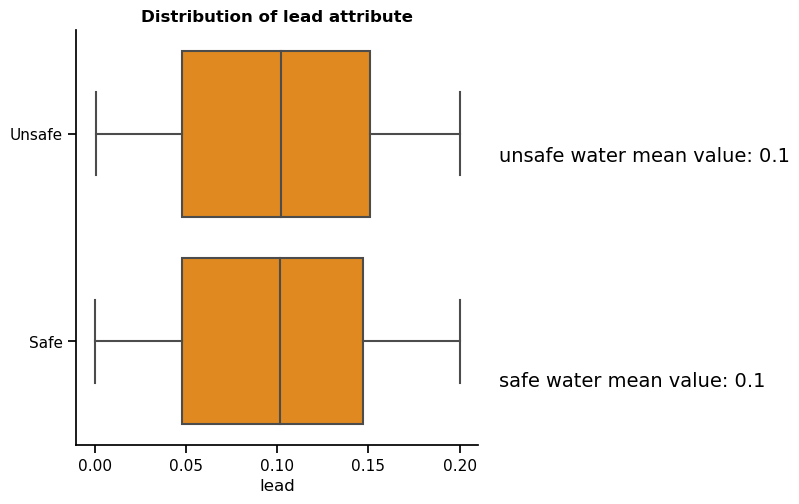

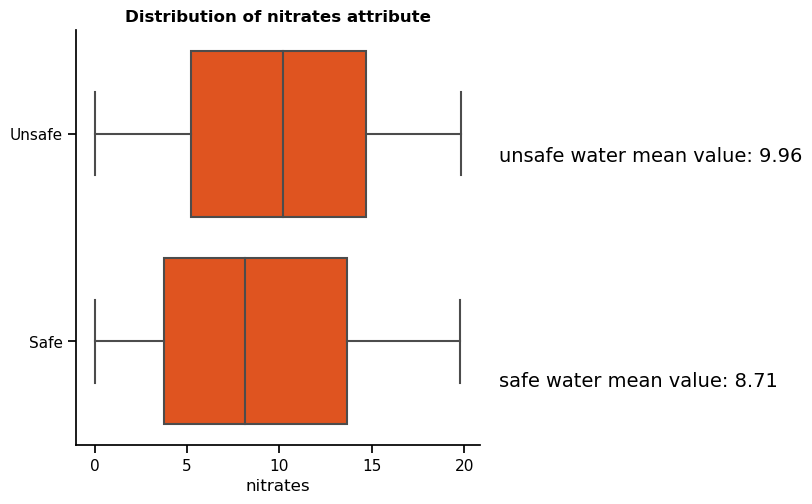

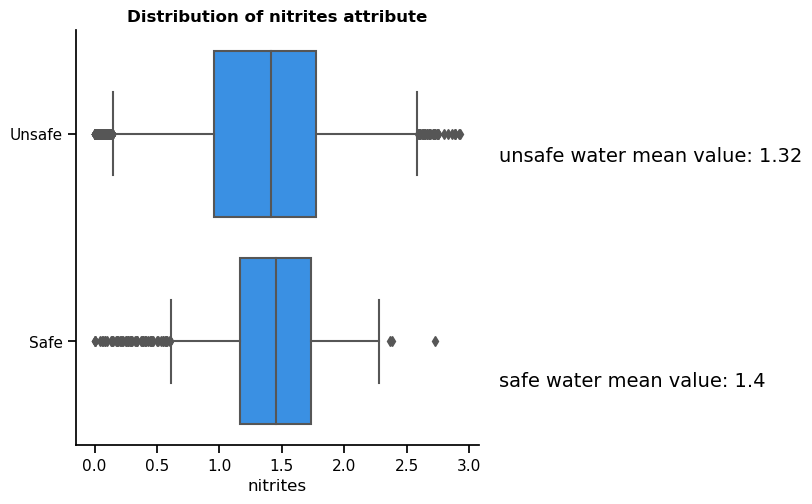

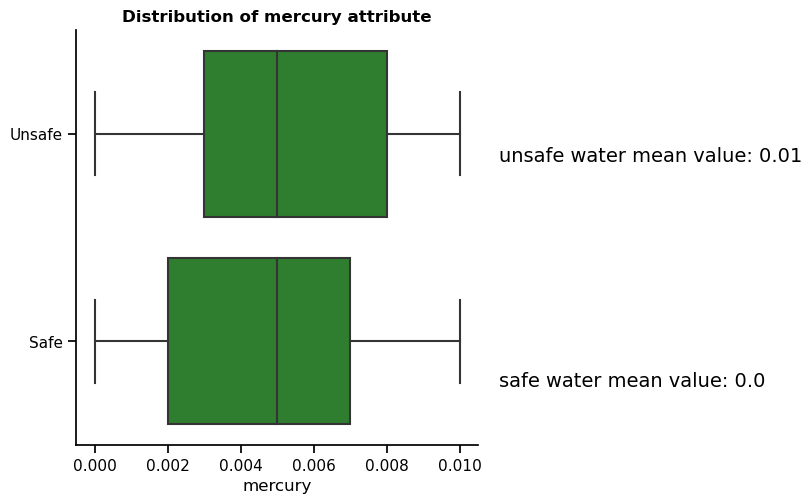

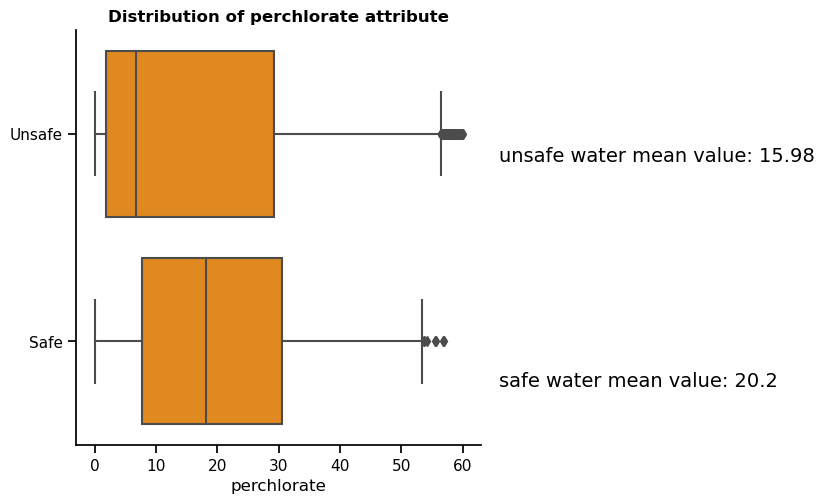

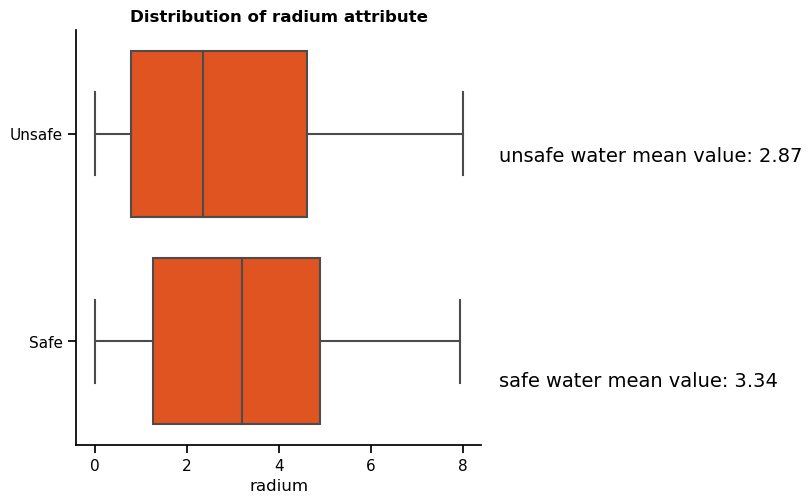

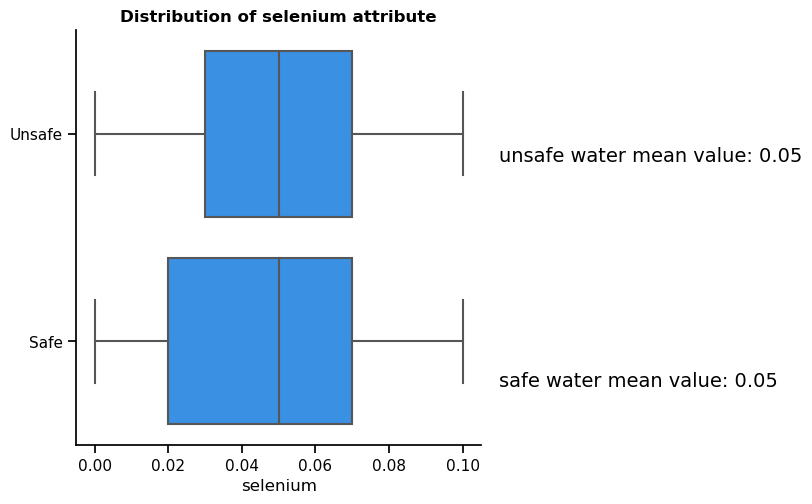

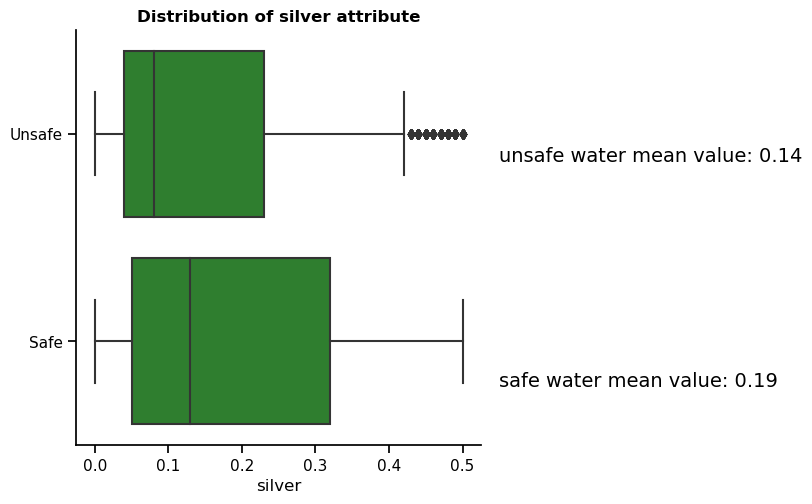

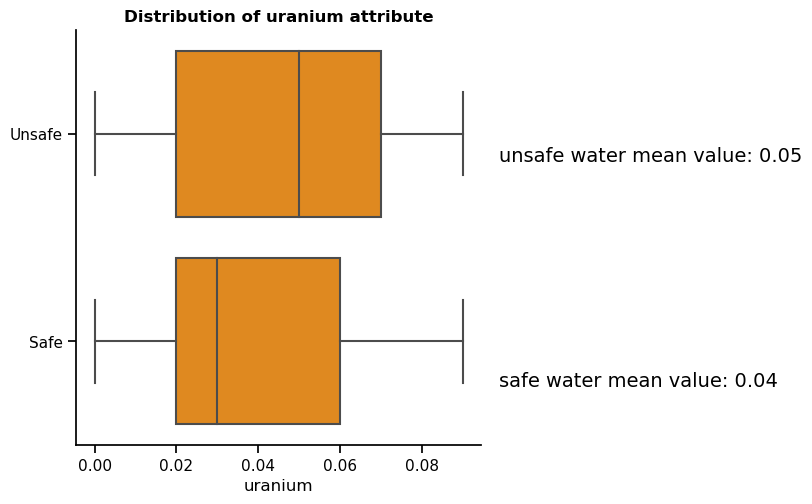

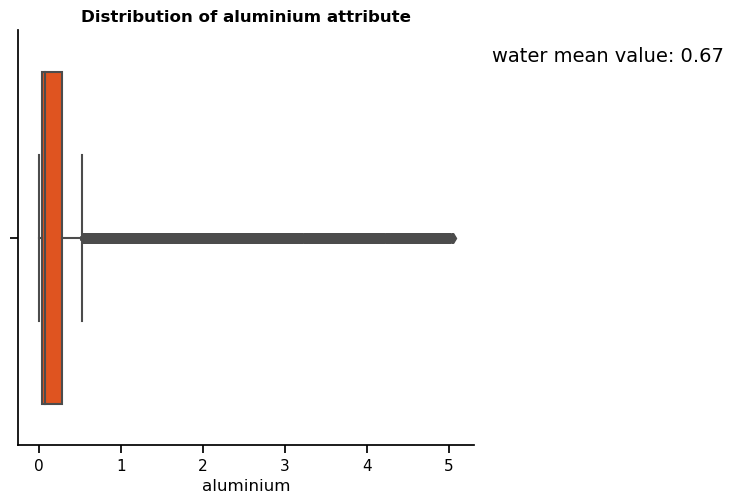

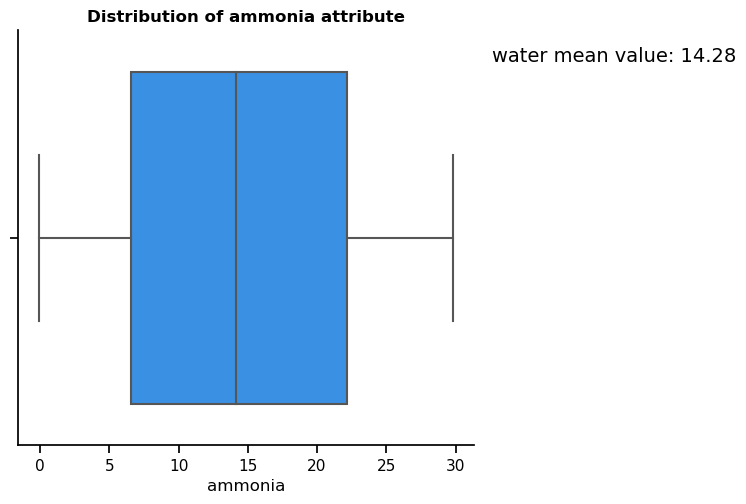

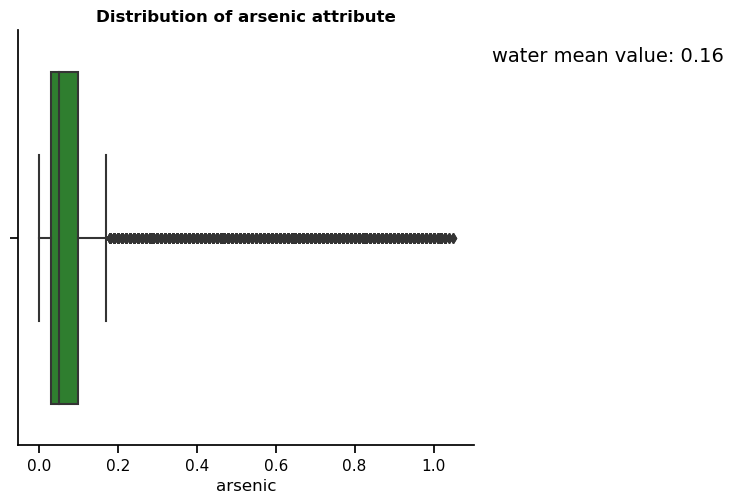

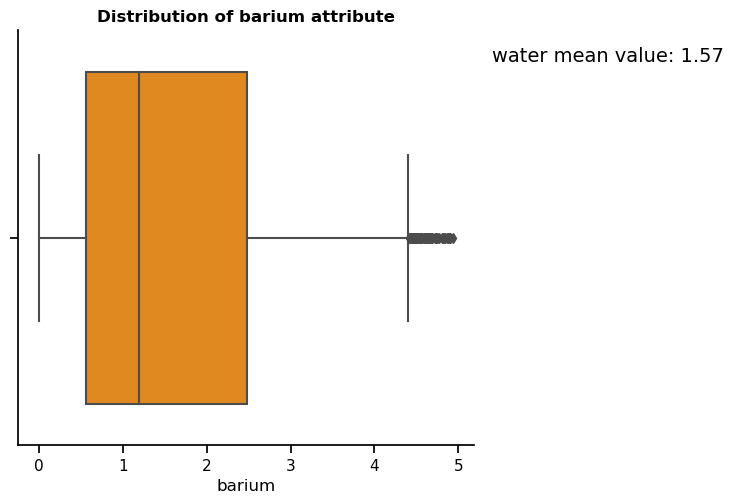

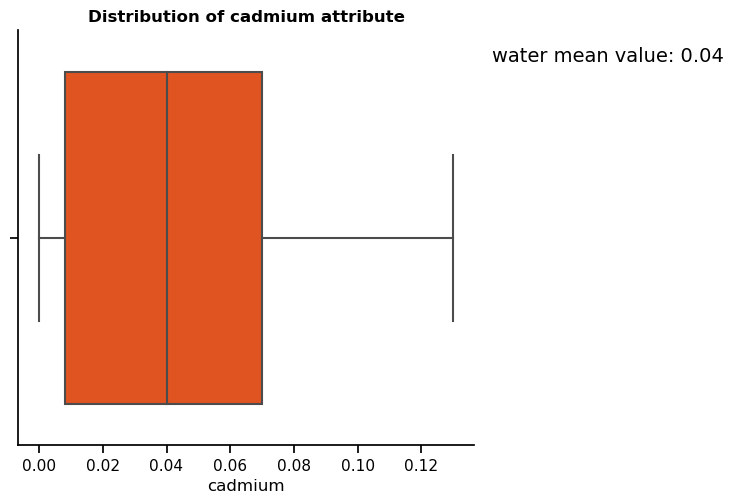

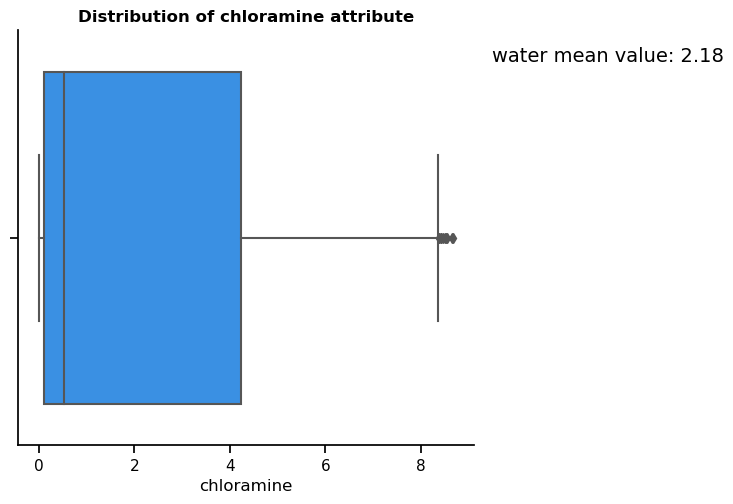

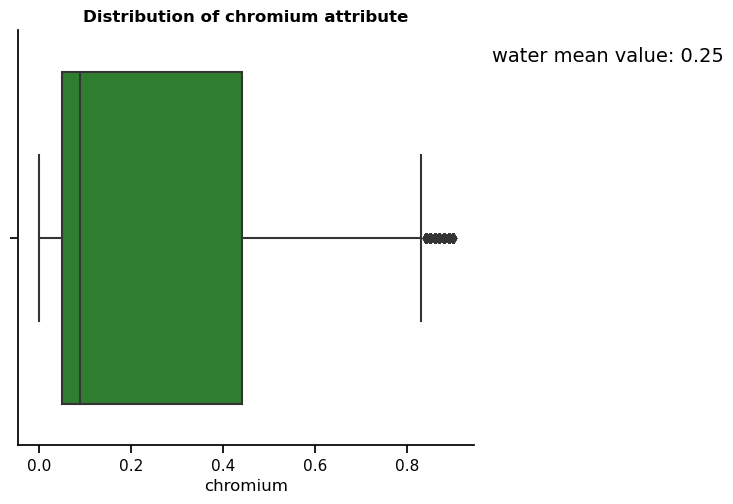

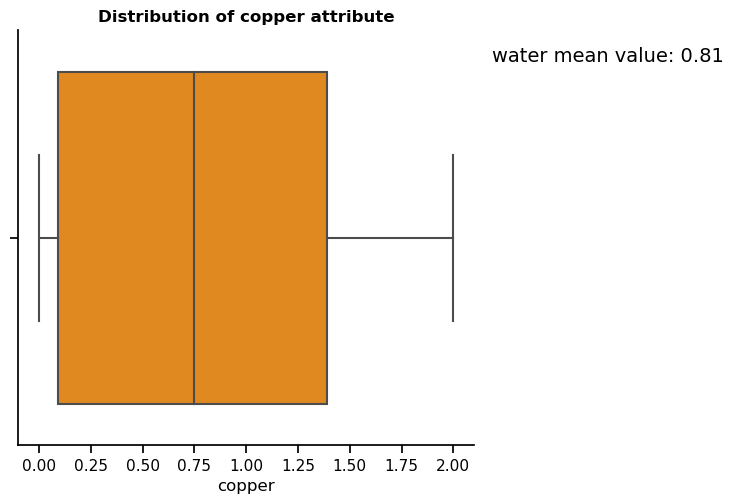

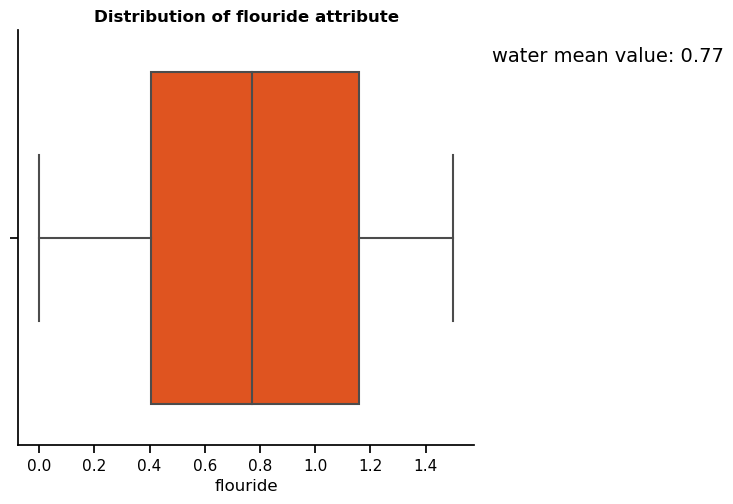

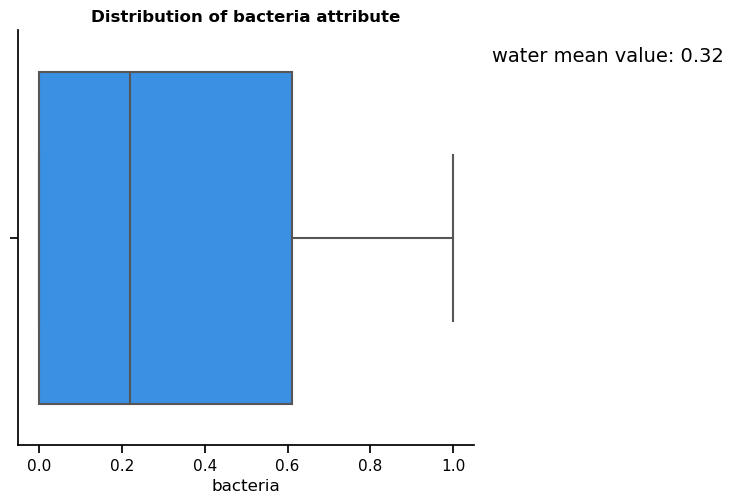

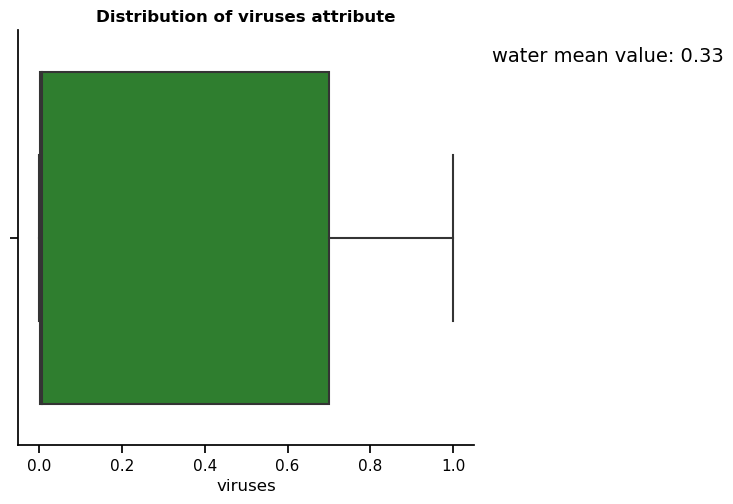

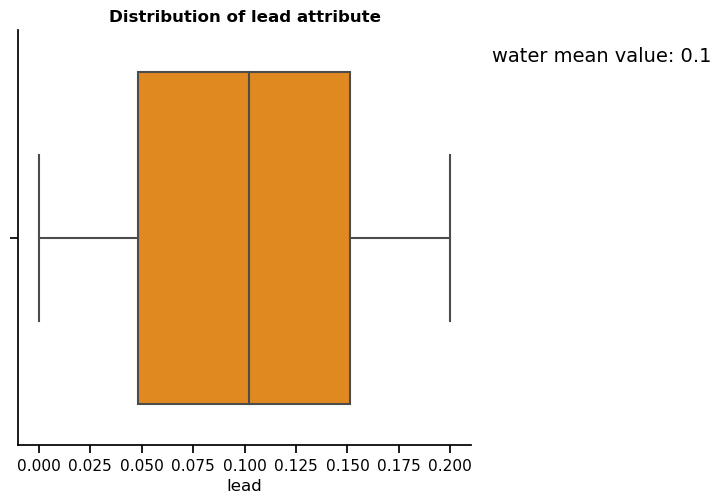

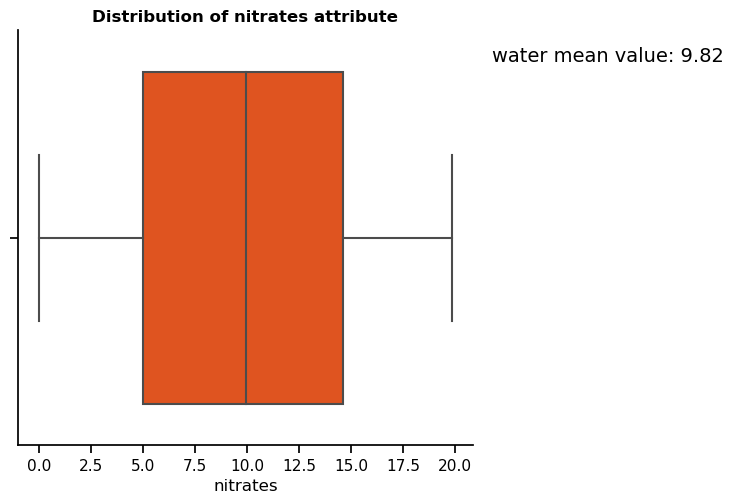

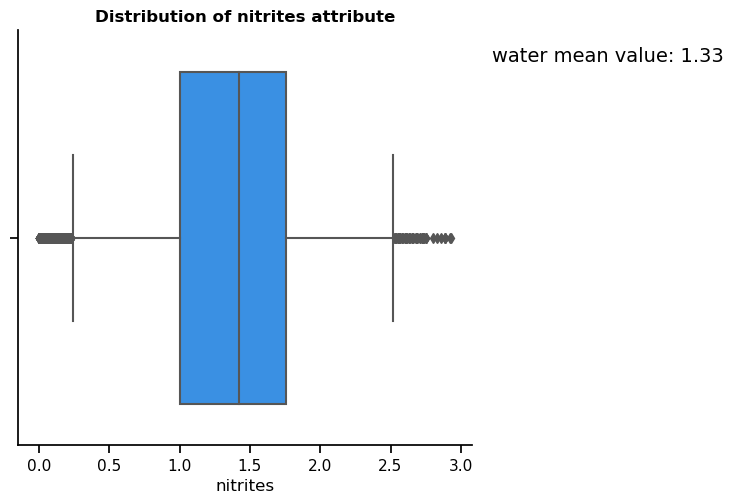

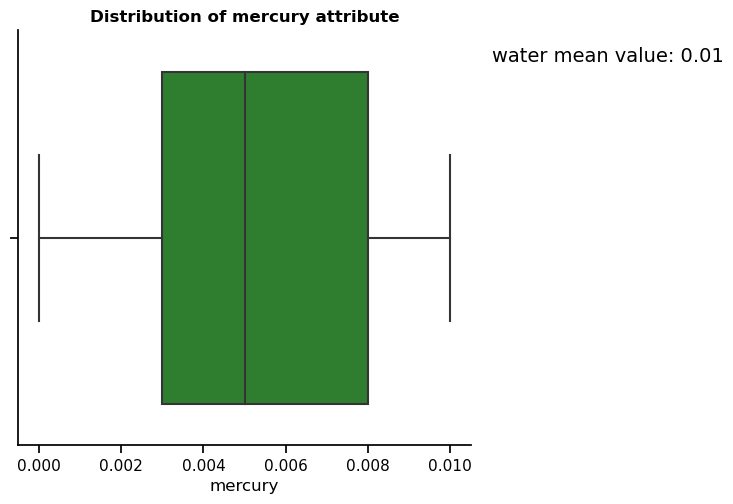

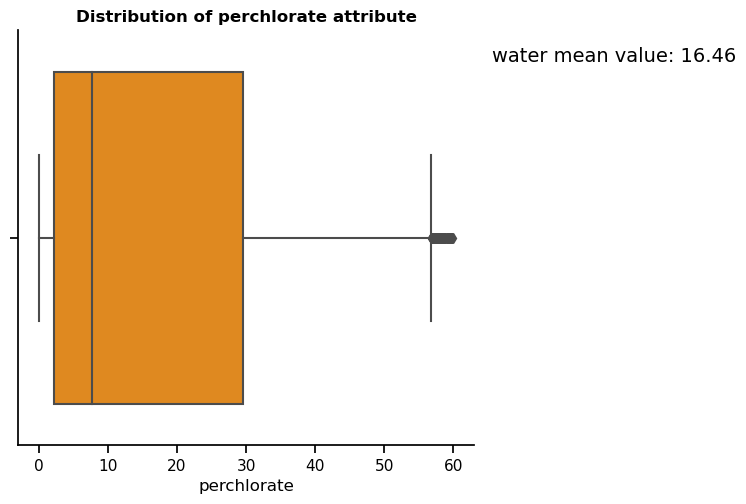

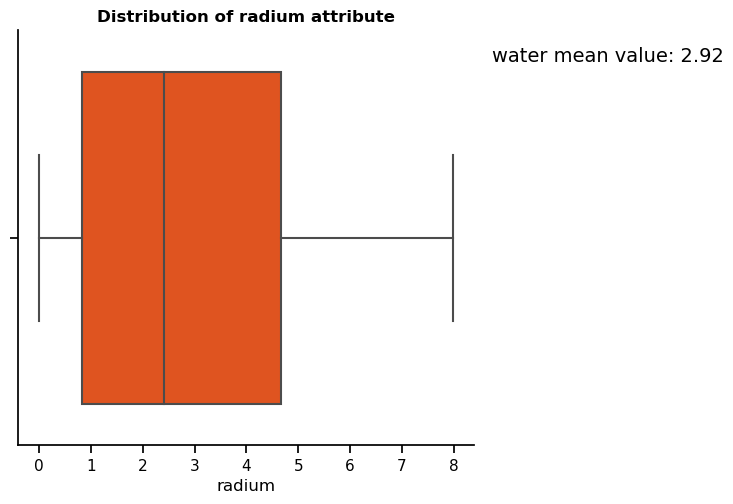

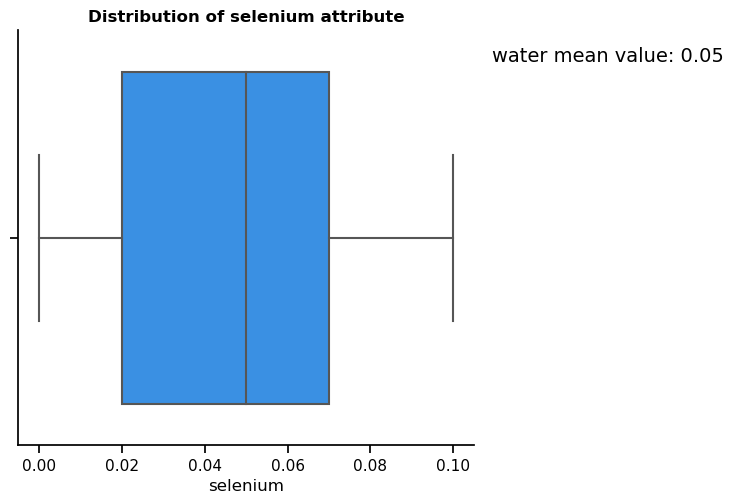

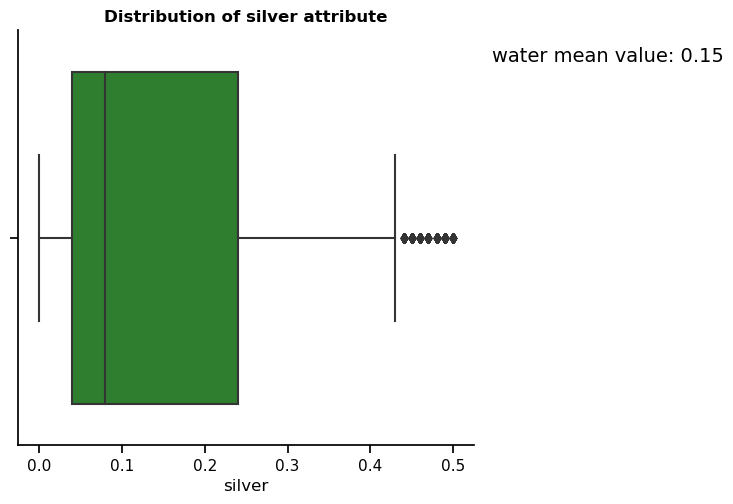

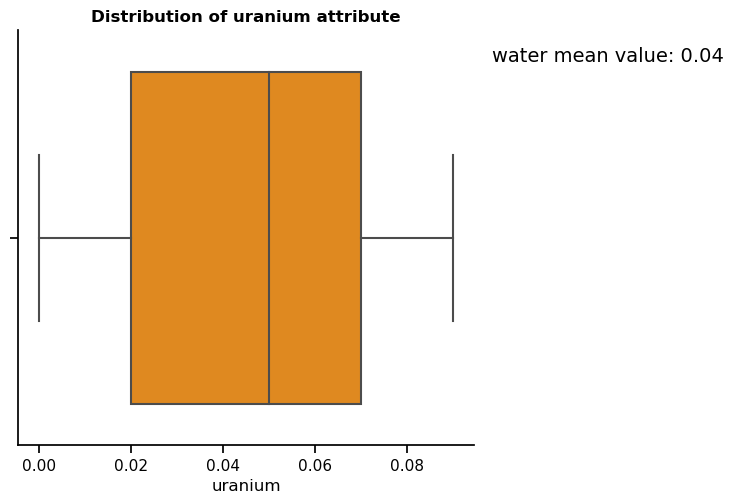

In [12]:
colors=[mcolors.CSS4_COLORS['orangered'], 
        mcolors.CSS4_COLORS['dodgerblue'], 
        mcolors.CSS4_COLORS['forestgreen'], 
        mcolors.CSS4_COLORS['darkorange']]*5

for idx, clm in enumerate(water_qlty_df.columns[:-1]):
    sns.catplot(data=water_qlty_df, x=clm, y='is_safe', 
                kind='box', whis=1, orient='h', color=colors[idx])
    plt.figtext(1, 0.70, 'unsafe water mean value: '+str(round(unsafe_df[clm].mean(),2)), size=14)
    plt.figtext(1, 0.25, 'safe water mean value: '+str(round(safe_df[clm].mean(),2)), size=14)
    plt.yticks([0,1], ['Unsafe','Safe'])
    plt.ylabel(None)
    plt.title('Distribution of {} attribute'.format(clm), fontweight='bold', size=12)
    plt.show()  



for idx, clm in enumerate(water_qlty_df.columns[:-1]):
    sns.catplot(x=clm, data=water_qlty_df, 
                kind='box', whis=1, orient='h', color=colors[idx])
    plt.figtext(1, 0.90, 'water mean value: '+str(round(water_qlty_df[clm].mean(),2)), size=14)
    plt.ylabel(None)
    plt.title('Distribution of {} attribute'.format(clm), fontweight='bold', size=12)
    plt.show() 
    
    

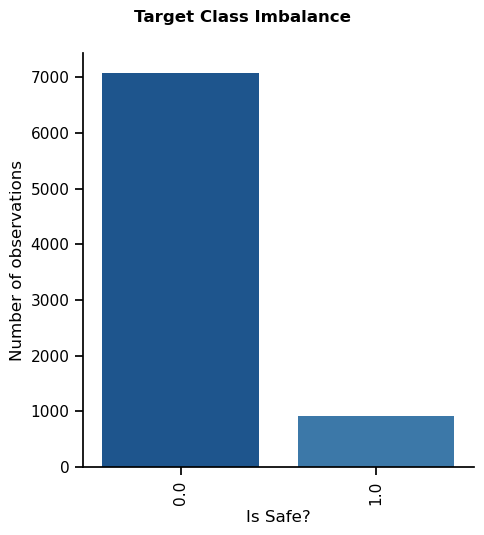

The target variabe 'Is Safe' is quite imbalanced with 88.59% of the instances considered unsafe water.


In [13]:
trgt_dist=pd.value_counts(water_qlty_df.is_safe, normalize=True)

sns.set_palette('Blues_r')
g=sns.catplot(x='is_safe', data=water_qlty_df, kind='count')
g.fig.suptitle('Target Class Imbalance', weight='bold',size=12, y=1.05)
_=plt.ylabel('Number of observations', size=12)
_=plt.xlabel('Is Safe?', size=12)
_=plt.xticks(rotation=90)
plt.show()

print('\033[1m'+'The target variabe \'Is Safe\' is quite imbalanced with {:.2f}% of the instances considered unsafe water.'.format(trgt_dist.iloc[0]*100))


In [14]:
rho=water_qlty_df.corr().round(2)
rho.style.background_gradient(cmap="Blues_r")


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
aluminium,1.000000,0.070000,0.230000,0.290000,-0.100000,0.370000,0.350000,0.170000,-0.010000,-0.080000,-0.070000,0.020000,-0.000000,0.240000,-0.000000,0.360000,0.240000,-0.000000,0.330000,0.010000,0.330000
ammonia,0.070000,1.000000,0.050000,0.070000,-0.010000,0.100000,0.120000,0.020000,-0.030000,0.060000,0.110000,-0.040000,0.010000,-0.060000,0.020000,0.090000,0.050000,0.030000,0.080000,0.010000,-0.020000
arsenic,0.230000,0.050000,1.000000,0.360000,0.330000,0.360000,0.310000,-0.040000,0.000000,0.040000,0.010000,-0.090000,0.030000,0.310000,-0.020000,0.330000,0.220000,-0.010000,0.310000,0.000000,-0.120000
barium,0.290000,0.070000,0.360000,1.000000,-0.040000,0.450000,0.420000,0.070000,-0.020000,0.100000,-0.000000,-0.040000,-0.010000,0.310000,0.010000,0.460000,0.290000,0.040000,0.430000,-0.000000,0.090000
cadmium,-0.100000,-0.010000,0.330000,-0.040000,1.000000,-0.140000,-0.160000,-0.110000,0.000000,-0.090000,0.020000,-0.030000,0.020000,-0.020000,-0.020000,-0.150000,-0.100000,0.010000,-0.160000,-0.010000,-0.260000
chloramine,0.370000,0.100000,0.360000,0.450000,-0.140000,1.000000,0.560000,0.120000,0.000000,0.150000,0.000000,-0.030000,-0.000000,0.380000,-0.020000,0.590000,0.390000,0.010000,0.520000,-0.010000,0.190000
chromium,0.350000,0.120000,0.310000,0.420000,-0.160000,0.560000,1.000000,0.110000,-0.000000,0.140000,0.000000,-0.050000,-0.010000,0.340000,-0.020000,0.520000,0.320000,0.030000,0.510000,-0.010000,0.180000
copper,0.170000,0.020000,-0.040000,0.070000,-0.110000,0.120000,0.110000,1.000000,0.010000,0.150000,0.010000,0.120000,0.000000,0.160000,0.020000,0.100000,0.030000,-0.000000,0.090000,0.010000,0.030000
flouride,-0.010000,-0.030000,0.000000,-0.020000,0.000000,0.000000,-0.000000,0.010000,1.000000,0.010000,0.020000,0.010000,-0.010000,-0.020000,-0.000000,-0.020000,0.010000,0.020000,0.010000,0.020000,0.010000
bacteria,-0.080000,0.060000,0.040000,0.100000,-0.090000,0.150000,0.140000,0.150000,0.010000,1.000000,0.620000,-0.030000,-0.030000,0.250000,-0.000000,0.150000,0.100000,-0.010000,0.150000,0.040000,-0.020000


#### EDA Findings:

The dataset is nearly fully populated.  Missing values for amonia can either be populated with its median value (14.13) or mean value (14.28), and the missing values for target classes will be filled with their most observed value, which in this case is 0 (unsafe water).  At either rate, these adjustments would not have much effect on the overall data.

The 'Safe vs. Unsafe Water: Statistical Measures of Numerical Variables' table partitions high level statistics by the target classes.  This presents some interesting findings between the classes.  The mean value of perchlorate (salt or ester of perchloric acid) in the safe water class is higher than in unsafe water, as are the differences in their median values (safe: 18.16 vs. unsafe: 6.78).  This is somewhat counter-intuituive as higher readings are considered unsafe.  The 'skew' column shows the relative 'tilt' of the variables' distibutions between the two classes (0 indicating it is perfectly bell-shaped).  The 'pval_nrml_dist' statistic is the p-value indicating whether the variable is normally distributed.  Since all p-values are below the 0.01 threshold, we can conclude the attributes are not normally distributed.

Going thru the various chemicals/predictor variables between the safe and unsafe water classes, it is hard to determine if differences in their mean values are statistically significant.  For each predictor variable, I randomly sample (with replacement) 100 data points from each class and generate t-tests.   At the 0.01 level of significance, the test results indicate a statistical difference in mean values between the safe and unsafe water class for aluminium, arsenic, barium, cadmium, chloramine, and perchlorate.  These variables might have high explanatory power in determining whether water is safe or not.  

The boxplots indicate the distribution of aluminium, arsenic, and cadmium having several outlier values.  The derived percentage of outliers ('perc_outliers') in the table show that arsenic and cadimium have 14% and 22% of their respective values considered outliers in the 'safe' class, and arsenic and aluminium have 22% and 20% of their values as outliers in the 'unsafe' class.    

The data review also highlights the class imbalance in the dataset.  Nearly 90% of the instances have a target label as 'unsafe.'  This will need to be addressed if we want to build a classifier with a high recall rate.  

Lastly, the correlation matrix indicates a linear relationships between chromium and chloramine, chloramine and perchlorate, perchlorate and chromium, and bacteria and viruses.  Given the possibility of multi-collinearity, dimensionalality reduction techniques would be useful.

### III: Data Preprocessing

In [15]:
#replace missing ammonia values with its median value
water_qlty_df.ammonia.fillna(value=water_qlty_df.ammonia.median(), inplace=True)

#take the most frequent class value
water_qlty_df.is_safe.fillna(value=water_qlty_df.is_safe.value_counts().index[0], inplace=True)

#set the target class values to integer
water_qlty_df['is_safe']=water_qlty_df.is_safe.astype('int')

In [16]:
water_qlty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   float64
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [17]:
X_train, X_test, y_train, y_test=train_test_split(water_qlty_df.iloc[:, :-1].values, 
                                                  water_qlty_df.iloc[:, -1].values,
                                                  test_size=0.3, 
                                                  random_state=42, stratify=water_qlty_df.iloc[:, -1])

print('The independent variables training dataset has {:d} instances and {:d} columns.'\
      .format(X_train.shape[0], X_train.shape[1]))
print('The dependent variables training dataset has {:d} instances. \n'.format(y_train.shape[0]))


print('The independent variables test dataset has {:d} instances and {:d} columns.'\
      .format(X_test.shape[0], X_test.shape[1]))
print('The dependent variables test dataset has {:d} instances. \n'.format(y_test.shape[0]))

The independent variables training dataset has 5599 instances and 20 columns.
The dependent variables training dataset has 5599 instances. 

The independent variables test dataset has 2400 instances and 20 columns.
The dependent variables test dataset has 2400 instances. 



In [18]:
y_test=y_test[:, np.newaxis]

print('y training set shape: ',y_train.shape)
print('y test set shape: ',y_test.shape)

y training set shape:  (5599,)
y test set shape:  (2400, 1)


#### Rebalance safe and unsafe classes to align instances thru upsampling

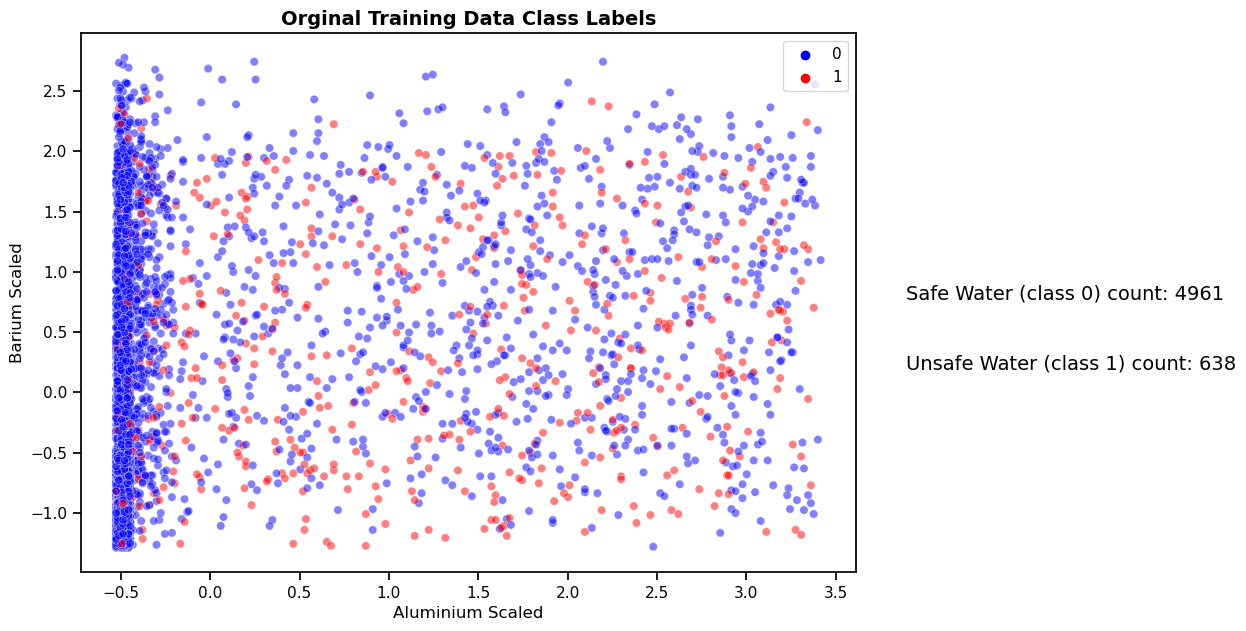

In [19]:
custom_palette = ["blue", 
                  "red"]

sns.set_palette(custom_palette)

std_sclr=StandardScaler()

X_train_scld=std_sclr.fit_transform(X_train)

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x=X_train_scld[:,0], y=X_train_scld[:,3], 
            data=X_train_scld, hue=y_train, ax=ax, alpha=0.5)
plt.figtext(0.95, 0.5, 'Safe Water (class 0) count: '+str(round(len(y_train[y_train==0]))), size=14)
plt.figtext(0.95, 0.4, 'Unsafe Water (class 1) count: '+str(round(len(y_train[y_train==1]))), size=14)
plt.title('Orginal Training Data Class Labels', weight='bold', size=14)
plt.legend(loc='upper right')
plt.xlabel('Aluminium Scaled')
plt.ylabel('Barium Scaled')
plt.show()

The above graph plots the aluminium and barium scaled values, using the StandardScaler, and the target classes.  The choice of using aluminium and barium was arbitrary and meant more to convey the higher prevalance of the 'unsafe' instances in the dataset.   

In [20]:
#create imbalance sampler instance using ADASYN class
adasyn_upsmplr=ADASYN(sampling_strategy='minority', random_state=42)
X_res, y_res=adasyn_upsmplr.fit_resample(X_train, y_train)
Counter(y_res)

Counter({0: 4961, 1: 4906})

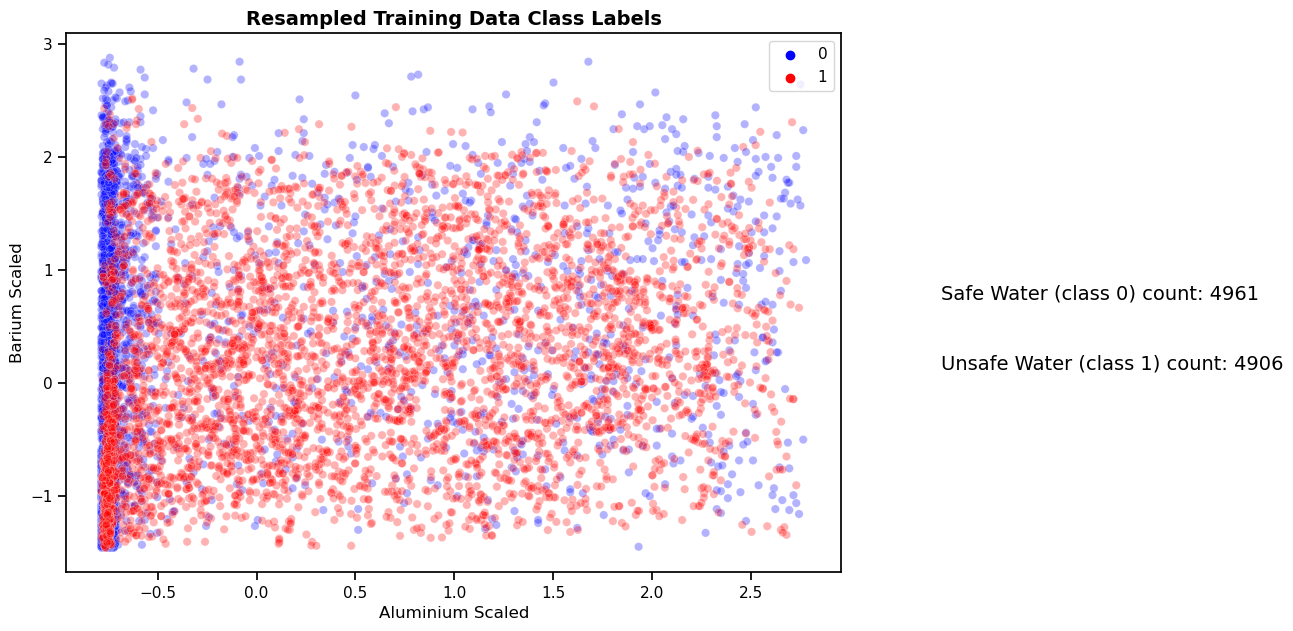

In [21]:
custom_palette = ["blue", 
                  "red"]

sns.set_palette(custom_palette)

std_sclr=StandardScaler()

X_train_scld=std_sclr.fit_transform(X_res)

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x=X_train_scld[:,0], y=X_train_scld[:,3], 
            data=X_train_scld, hue=y_res, ax=ax, alpha=0.3)
plt.figtext(1, 0.5, 'Safe Water (class 0) count: '+str(round(len(y_res[y_res==0]))), size=14)
plt.figtext(1, 0.4, 'Unsafe Water (class 1) count: '+str(round(len(y_res[y_res==1]))), size=14)
plt.title('Resampled Training Data Class Labels', weight='bold', size=14)
plt.legend(loc='upper right')
plt.xlabel('Aluminium Scaled')
plt.ylabel('Barium Scaled')

plt.show()

In [22]:
outlier_lst=['aluminium', 'arsenic', 'cadmium']
clm_lst=pd.Series(water_qlty_df.columns).to_list()

rbst_sclr_data=[clm_lst.index(i) for i in clm_lst if i in outlier_lst]
std_sclr_data=[clm_lst.index(i) for i in clm_lst if i not in outlier_lst][:-1]

print('robust scaler variable indices', rbst_sclr_data)
print('standard scaler variable indices', std_sclr_data)

robust scaler variable indices [0, 2, 4]
standard scaler variable indices [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [23]:
rbst_sclr=RobustScaler()
std_sclr=StandardScaler()

preprocessing=ColumnTransformer([('robust_scaler', rbst_sclr, rbst_sclr_data),
                                 ('standard_scaler', std_sclr, std_sclr_data)])

All missing value data is imputed, and the dataset is further split 70:30 into training and testing sets, respectively.  The training dataset will be used to tune the hyperparameters and fit several machine learning classifiers.   The exploratory data review indicated the positive class was underrepresented and made up 11% of the dataset instances.  Training ML models with the incidence of the class 1 (safe water) will likely affect the model's ability to indentify true instances of the class.  The ADYSEN (Adaptive Synthetic) oversampling technique was used to create instances of class 1 thru oversampling to be more inline with the majority class instances.  ADYSEN is similar to  SMOTE (Synthetic Minority Oversampling Technique), another oversampling techique.  While both techniques generate new class samples by interpolation of nearby data points (i.e., KNeighbors), ADYSEN generates different number of samples depending on the local distribution of the class to be oversampled.

Since all the attribute values are continuous, numeric values with different measurement scales, they are rescaled to ensure the model algorithms converge and the results are reliable.  Given aluminium, arsenic, and cadmium contained a high percentage of outlier values, the RobustScaler() class is more appropriate for these atributes.  All other attribute are scaled using StandardScaler().  The ColumnTransformer class streamlines the above steps by fitting and transforming the attributes according to the relevant scaler method and returning recompiled dataset post transformations.

## IV: Model Selection and Evaluation

#### -- Logistic Model

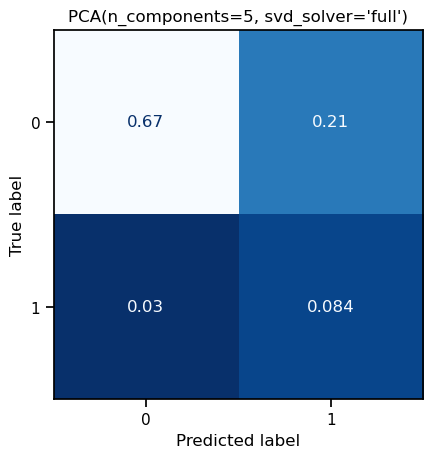

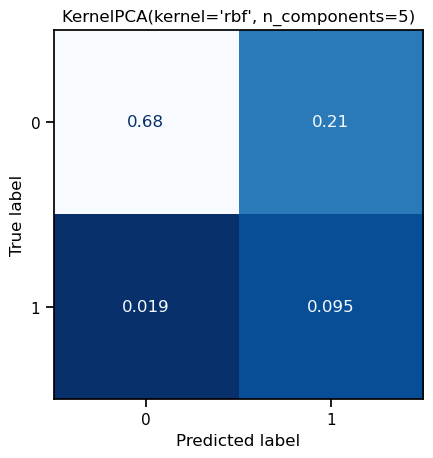

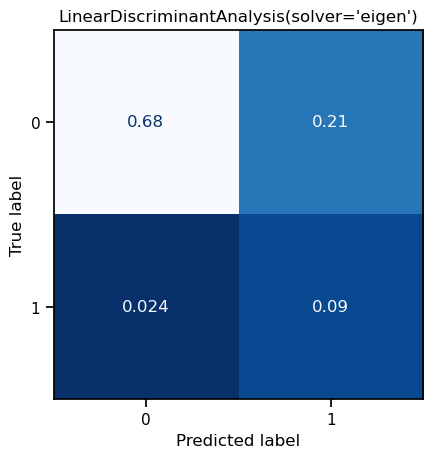

,dim_reducnt_type,accuracy_train,precision_train,recall_train,F1_train
1,kernelpca,0.77,0.31,0.83,0.46
2,lineardiscriminantanalysis,0.77,0.30,0.79,0.44
0,pca,0.76,0.28,0.74,0.41


In [24]:
np.random.seed(42)

pca=PCA(n_components=5, svd_solver='full')

lda=LDA(solver='eigen')

kpca=KernelPCA(n_components=5, kernel='rbf')

#create a dictionary of dimensionality reduction methods
pca_type_dct={'pca': pca, 'kernelpca': kpca, 'lineardiscriminantanalysis': lda }

#lists to hold metric outputs using the different dimensionality techniques 
dim_redctn_type=[]
train_scre=[]
prec_score_trn=[]
recl_score_trn=[]
f1_score_trn=[]

for k, v in pca_type_dct.items():
    pipe= imblnc_make_pipeline(preprocessing, 
                               adasyn_upsmplr,
                                v,
                               LogisticRegression())
    lr_mdl=pipe.fit(X_train, y_train)
    
    #predict on the training training set
    y_pred=lr_mdl.predict(X_train)
    
    dim_redctn_type.append(k)
    train_scre.append(np.around(lr_mdl.score(X_train, y_train),2))
    prec_score_trn.append(np.around(precision_score(y_train, y_pred),2))
    recl_score_trn.append(np.around(recall_score(y_train, y_pred),2))
    f1_score_trn.append(np.around(f1_score(y_train, y_pred),2))
    cm = confusion_matrix(y_train, y_pred, labels=lr_mdl.classes_, normalize='all')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_mdl.classes_,
                               )
    disp.plot(cmap="Blues_r", colorbar=False)
    plt.title(v)
    plt.show()

   
    
    
dim_redctn_df=pd.DataFrame({'dim_reducnt_type': dim_redctn_type, 
                            'accuracy_train': train_scre, 
                            'precision_train': prec_score_trn,
                             'recall_train': recl_score_trn,
                             'F1_train': f1_score_trn})

dim_redctn_df.sort_values(by=['accuracy_train'], ascending=False)

In [25]:
#Kernel PCA Pipeline
kpca_pipe= imblnc_make_pipeline(preprocessing, adasyn_upsmplr, kpca, LogisticRegression())
validation_set_scores=cross_val_score(estimator=kpca_pipe, X=X_train, y=y_train, cv=10, scoring='recall')
print('Kernel PCA: recall scores on validation sets: ',np.around(validation_set_scores,3),)
print('Kernel PCA: recall precision score on validation sets {:.2f}'.format(np.mean(validation_set_scores)))
print('Kernel PCA: standard deviation recall score on validation sets {:.2f}\n'.format(np.std(validation_set_scores)))

#LDA Pipeline
lda_pipe= imblnc_make_pipeline(preprocessing, adasyn_upsmplr, lda, LogisticRegression())
validation_set_scores=cross_val_score(estimator=lda_pipe, X=X_train, y=y_train, cv=10, scoring='recall')
print('LDA: recall scores on validation sets: ',np.around(validation_set_scores,3),)
print('LDA: recall precision score on validation sets {:.2f}'.format(np.mean(validation_set_scores)))
print('LDA: standard deviation recall score on validation sets {:.2f}\n'.format(np.std(validation_set_scores)))

Kernel PCA: recall scores on validation sets:  [0.778 0.812 0.906 0.828 0.859 0.844 0.812 0.828 0.812 0.794]
Kernel PCA: recall precision score on validation sets 0.83
Kernel PCA: standard deviation recall score on validation sets 0.03

LDA: recall scores on validation sets:  [0.683 0.781 0.828 0.719 0.75  0.875 0.828 0.812 0.766 0.746]
LDA: recall precision score on validation sets 0.78
LDA: standard deviation recall score on validation sets 0.05



The standard PCA, Linear Discriminant Analysis, and kernal PCA dimensionality reduction techniques are each tested on a pipeline with an unregularized logistic model as the end estimator.  While PCA is suitable for classes that are linearly separable, kPCA handles classes that are not linearly separable.  LDA, like PCA, is another linear dimensionality reduction technque though it is a supervised form and finds the feature subspace that optimizes class separability.  

The resulting evaluation measures indicates kPCA provides the best overall results on the model.  This benefit though comes at a cost as the process is computationally expensive.  LDA comes in at a close second.  Comparing kPCA to LDA thru a cross validation on the training dataset, kPCA still provides better results.  However, since kPCA requires higher processing time and computation, LDA will be used as the dimnsionality technique of choice in the pipeline diagram below.

<img src="Pipeline_Diagram.png" width=1000, height=1000>

The pipeline above shows the data flow and transformations and estimation process.  The steps are to first prepocess the attribute data using the ColumnTransformer, then upsample using ADASYN, then do dimensionality reduction using LDA, and finally create instance of ML classifier to fit the models.  This pipeline process will be used for all the models examined and evaluated. 

In [26]:
def best_params(srch_func, pipe, param_grid, cv=10, n_iter=None):
    """
    function uses a either sklearn 
    GridSearchCV or RandomizedSearchCV
    for optimal hyperparameter search for f1 score
    using 10 fold cross validation:

    Parameters
    ----------
    
    srch_func: 
        GridSearchCV or RandomizedSearchCV
        
    pipe: Pipeline
        instantiated pipeline
    
    param_grid: dict or list of dictionaries
        dictionary or list of dictionaries with 
        paramter names as keys and values 
        
        note: using RandomizedSearchCV requires 
        values to be numeric
    cv: int, default=10
        number of cross validation folds to generate
    
    n_iter: int, optional, default=None
        only relevant if running RandomizedSearchCV
        number of random samples of param_grid 
        combinations to use in RandomizedSearchCV 
    
    Returns: 
    -------
    tuple
    
    fitted model with hyperparameter values of highest f1 score,
    accuracy score of validation model with highest f1 score,
    precision score of validation model with highest f1 score
    recall score of validation model with highest f1 score
    highest f1 score of validation model"""
    
    if srch_func==GridSearchCV:
    
        best_params_srch=srch_func(estimator=pipe, 
                                  param_grid=param_grid,
                                  cv=cv,
                                  scoring=['accuracy', 'precision', 'recall', 'f1'], 
                                  refit='f1', 
                                  n_jobs=-1,
                                  verbose=True)
        
        best_params_srch.fit(X_train, y_train)
        
        print('\n\033[1m'+'Best Hyperparameter Values for Optimizing f1 Score: {}\n'.\
              format(best_params_srch.estimator[-1]))
        
        for k, v in best_params_srch.best_params_.items():
            print('\033[1m'+'{}: {}'.format(k,v))
    
        print('\n\033[1m'+'Best f1 Score from Validation Sets {:.4f}'.format(best_params_srch.best_score_))
    
        
        best_f1_idx=np.argmin(best_params_srch.cv_results_['rank_test_f1'])
        
        validation_set_mean_accuracy=np.around(best_params_srch.cv_results_['mean_test_accuracy']\
                                               [best_f1_idx],2)
        
        validation_set_mean_precision=np.around(best_params_srch.cv_results_['mean_test_precision']\
                                                [best_f1_idx],2)
        
        validation_set_mean_recall=np.around(best_params_srch.cv_results_['mean_test_recall']\
                                                [best_f1_idx],2) 
        
        validation_set_mean_f1=np.around(best_params_srch.cv_results_['mean_test_f1']\
                                         [best_f1_idx],2)

        
    elif srch_func==RandomizedSearchCV:
        
        best_params_srch=srch_func(estimator=pipe, 
                                   param_distributions=param_grid,
                                   cv=cv,
                                   scoring=['accuracy', 'precision', 'recall', 'f1'], 
                                   refit='f1', 
                                   n_jobs=-1, 
                                   verbose=True,
                                   random_state=42)
        
        best_params_srch.fit(X_train, y_train)
    
        print('\n\033[1m'+'Best Hyperparameter Values for Optimizing f1 Score: {}\n'.\
              format(best_params_srch.estimator[-1]))
        
        for k, v in best_params_srch.best_params_.items():
            print('\033[1m'+'{}: {}'.format(k,v))
    
        print('\n\033[1m'+'Best f1 Score from Validation Sets {:.4f}'.format(best_params_srch.best_score_))
    
        best_f1_idx=np.argmin(best_params_srch.cv_results_['rank_test_f1'])
        
        validation_set_mean_accuracy=np.around(best_params_srch.cv_results_['mean_test_accuracy']\
                                               [best_f1_idx],2)
        
        validation_set_mean_precision=np.around(best_params_srch.cv_results_['mean_test_precision']\
                                                [best_f1_idx],2)
        
        validation_set_mean_recall=np.around(best_params_srch.cv_results_['mean_test_recall']\
                                                [best_f1_idx],2) 
        
        validation_set_mean_f1=np.around(best_params_srch.cv_results_['mean_test_f1']\
                                         [best_f1_idx],2)


        
    return (best_params_srch, validation_set_mean_accuracy, validation_set_mean_precision, 
            validation_set_mean_recall, validation_set_mean_f1)



Since the analysis will evaluate several classification models, a function is implemented to streamline the hypertuning and cross fold validation processing.  The best_params function takes either the sklearn GridSearchCV or RandomSearchCV class as first argument, a model pipeline, a param grid list containing a dictionary of containing hyperparameter key: values to evaluate on, the number of folds (default 10), and the number of iterations if RandomSearchCV is used (optional and defaulting to 10 under RandomSearchCV).  

Once function parameters are input, the function can run a GridSearchCV/RandomedSearchCV and return a fitted model with the optimal hyperparameter values that returned the highest f1 score, as well the accuracy, precesion, recall, and f1 scores associated with the highest f1 score validation fold. 

### Logistic Regression Classifier
####   &nbsp; &nbsp; Hypertune Parameters 
####   &nbsp; &nbsp; &nbsp; GridSearchCV

In [27]:
#make logistic regression pipeline
lc_pipe=imblnc_make_pipeline(preprocessing, adasyn_upsmplr, lda, LogisticRegression(verbose=True,
                                                                                    random_state=42))

regularization_params=[0.001, 0.01, 0.1, 1, 100, 1000]
param_grid=[{'logisticregression__C': regularization_params,
             'logisticregression__penalty': ['l1', 'l2'],
             'logisticregression__solver': ['liblinear']
             },
            
              {'logisticregression__C': regularization_params,
             'logisticregression__penalty': ['elasticnet'],
             'logisticregression__solver': ['saga'],
             'logisticregression__l1_ratio': [*np.arange(0.3,0.7, 0.1)]
             }]

lc_grid_srch, lc_acc, lc_prcsn, lc_recl, lc_f1=best_params(GridSearchCV, lc_pipe, param_grid)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.557309
#nonzeros/#features = 1/2
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.590216
#nonzeros/#features = 1/2
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.531339
#nonzeros/#features = 1/2
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.565320
#nonzeros/#features = 1/2
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.577074
#nonzeros/#features = 1/2
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.544820
#nonzeros/#features = 1/2
iter   

iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   9  #CD cycles 1
optimization finished, #iter = 9
Objective value = 431.989652
#nonzeros/#features = 2/2
iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   9  #CD cycles 1
optimization finished, #iter = 9
Objective value = 427.414309
#nonzeros/#features = 2/2
iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   9  #CD cycles 1
optimization finished, #iter = 9
Objective value = 438.145356
#nonzeros/#features = 2/2
iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1


iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   9  #CD cycles 1
optimization finished, #iter = 9
Objective value = 425025.776940
#nonzeros/#features = 2/2
iter  1 act 1.775e+05 pre 1.589e+05 delta 1.269e+00 f 6.229e+05 |g| 3.342e+05 CG   2
iter  2 act 1.511e+04 pre 1.339e+04 delta 1.269e+00 f 4.455e+05 |g| 6.823e+04 CG   2
iter  3 act 7.366e+02 pre 7.087e+02 delta 1.269e+00 f 4.304e+05 |g| 1.264e+04 CG   2
iter  4 act 2.734e+00 pre 2.727e+00 delta 1.269e+00 f 4.296e+05 |g| 7.389e+02 CG   2
iter   1  #CD cycles 2
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 1
iter   8  #CD cycles 1
iter   9  #CD cycles 2
optimization finished, #iter = 9
Objective value = 421585.221269
#nonzeros/#features = 2/2
iter  1 act 1.693e+03 pre 1.516e+03 delta 1.270e+00 f 6.160e+03 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[P

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[LibLinear]iter  1 act 1.851e+01 pre 1.672e+01 delta 1.200e+00 f 6.893e+01 |g| 3.643e+01 CG   2
iter  2 act 1.218e+00 pre 1.107e+00 delta 1.200e+00 f 5.042e+01 |g| 6.954e+00 CG   2
iter  3 act 3.362e-02 pre 3.291e-02 delta 1.200e+00 f 4.920e+01 |g| 1.034e+00 CG   2
iter  4 act 3.639e-05 pre 3.636e-05 delta 1.200e+00 f 4.917e+01 |g| 3.387e-02 CG   2

Best Hyperparameter Values for Optimizing f1 Score: LogisticRegression(random_state=42, verbose=True)

logisticregression__C: 0.01
logisticregression__penalty: l2
logisticregression__solver: liblinear

Best f1 Score from Validation Sets 0.4348


In [28]:
#get metrics from validation set and input into dataframe 
iterables = [['logistic_model'], ['Accuracy', 'Precision', 'Recall', 'F1']]

array=pd.MultiIndex.from_product(iterables, names=['model', 'metrics'])

lc_mdl_df=pd.DataFrame({'Validation Set': [lc_acc, lc_prcsn, lc_recl, lc_f1]},
                                                        index=array)

In [29]:
lc_mdl_df.unstack()

Validation Set                       
metrics              Accuracy    F1 Precision Recall
model                                               
logistic_model           0.76  0.43       0.3    0.8

The best_params function using GridSearchCV, a pipeline with the logistic regression model, and different C and penality hyperparameter settings returns a C regularization parameter value of 0.01 and an 'l2' penalty term.  The  accuracy,  precision, recall, and f1 evaluation measures based off the validation model with the highest f1 score (0.4348) are displayed above. The recall rate is relatively good at 0.80 indicating the model is somewhat decent at detecting positive class values.  The precision score of 0.30 is low however, and is indicative of the model having a high number of false positives.   

### Support Vector Machine Classifier
####   &nbsp; &nbsp; Hypertune Parameters 
####   &nbsp; &nbsp; &nbsp; RandomizedSearchCV

In [30]:
#make SVC pipeline
svc_pipe= imblnc_make_pipeline(preprocessing, adasyn_upsmplr, lda, SVC(kernel='rbf', 
                                                                       verbose=True)
                              )

regularization_params=[0.001, 0.01, 0.1, 1, 100, 1000]
gamma_params=[0.001, 0.01, 0.1]

print('Regularization Sample Values:\n', regularization_params, '\n')
print('gamma Sample Values:\n', gamma_params, '\n')


param_dists=[{'svc__C': regularization_params,
             'svc__gamma': gamma_params}]

svc_grid_srch, svc_acc, svc_prcsn, svc_recl, svc_f1=best_params(srch_func=RandomizedSearchCV, 
                                                                 pipe=svc_pipe,
                                                                 param_grid=param_dists)

Regularization Sample Values:
 [0.001, 0.01, 0.1, 1, 100, 1000] 

gamma Sample Values:
 [0.001, 0.01, 0.1] 

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Epoch 1, change: 1.00000000
Epoch 2, change: 0.13147196
Epoch 3, change: 0.03086882
Epoch 4, change: 0.04632265
Epoch 5, change: 0.00831427
Epoch 6, change: 0.00696460
Epoch 7, change: 0.00276528
Epoch 8, change: 0.00276651
Epoch 9, change: 0.00089871
Epoch 1, change: 1.00000000
Epoch 2, change: 0.19356508
Epoch 3, change: 0.04854422
Epoch 4, change: 0.00189297
Epoch 5, change: 0.01133774
Epoch 6, change: 0.07379064
Epoch 7, change: 0.05944961
Epoch 8, change: 0.00020534
Epoch 9, change: 0.00048650
Epoch 10, change: 0.00085553
Epoch 11, change: 0.00082903
Epoch 1, change: 1.00000000
Epoch 2, change: 0.14443600
Epoch 3, change: 0.03244166
Epoch 4, change: 0.05130019
Epoch 5, change: 0.00895010
Epoch 6, change: 0.00845537
Epoch 7, change: 0.00233831
Epoch 8, change: 0.00290599
Epoch 9, change: 0.00106870
Epoch 1, chang

Epoch 3, change: 0.08322101
Epoch 4, change: 0.05272984
Epoch 5, change: 0.01252801
Epoch 6, change: 0.00807782
Epoch 7, change: 0.00378495
Epoch 8, change: 0.00126776
Epoch 9, change: 0.00113815
Epoch 10, change: 0.00049134
Epoch 1, change: 1.00000000
Epoch 2, change: 0.06575407
Epoch 3, change: 0.03127057
Epoch 4, change: 0.01972972
Epoch 5, change: 0.01327535
Epoch 6, change: 0.00351574
Epoch 7, change: 0.00234307
Epoch 8, change: 0.00071490
Epoch 9, change: 0.00110645
Epoch 10, change: 0.00049798
Epoch 1, change: 1.00000000
Epoch 2, change: 0.07842902
Epoch 3, change: 0.06271291
Epoch 4, change: 0.00010404
Epoch 5, change: 0.02325024
Epoch 6, change: 0.00053331
Epoch 7, change: 0.00218614
Epoch 8, change: 0.00260990
Epoch 9, change: 0.00114937
Epoch 10, change: 0.00075993
Epoch 1, change: 1.00000000
Epoch 2, change: 0.06105161
Epoch 3, change: 0.10027577
Epoch 4, change: 0.00720497
Epoch 5, change: 0.00401676
Epoch 6, change: 0.00369540
Epoch 7, change: 0.00167777
Epoch 8, change: 

Epoch 10, change: 0.00056002
Epoch 11, change: 0.00044239
Epoch 12, change: 0.00128426
Epoch 13, change: 0.00049546
Epoch 1, change: 1.00000000
Epoch 2, change: 0.07176578
Epoch 3, change: 0.03781140
Epoch 4, change: 0.02248917
Epoch 5, change: 0.01505626
Epoch 6, change: 0.00388651
Epoch 7, change: 0.00228402
Epoch 8, change: 0.00073273
Epoch 9, change: 0.00111914
Epoch 10, change: 0.00052072
...............................
*
optimization finished, #iter = 4469
obj = -8.805138, rho = -0.963482
nSV = 8844, nBSV = 8844
Total nSV = 8844

*
optimization finished, #iter = 4500
obj = -8.886595, rho = 0.955538
nSV = 8930, nBSV = 8930
Total nSV = 8930

*
optimization finished, #iter = 4488
obj = -8.887280, rho = 0.956174
nSV = 8930, nBSV = 8930
Total nSV = 8930

*
optimization finished, #iter = 4555
obj = -8.890102, rho = 0.965329
nSV = 8930, nBSV = 8930
Total nSV = 8930

*
optimization finished, #iter = 4513
obj = -8.889793, rho = 0.957551
nSV = 8930, nBSV = 8930
Total nSV = 8930

*
optimiza

/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 10 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 12 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 12 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 11

[LibSVM][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 12 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 12 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 12 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
r


*
optimization finished, #iter = 4594
obj = -8.552366, rho = 0.686467
nSV = 8930, nBSV = 8930
Total nSV = 8930

*
optimization finished, #iter = 4568
obj = -8.485040, rho = -0.622758
nSV = 8894, nBSV = 8894
Total nSV = 8894


/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......................
*
optimization finished, #iter = 3418
obj = -465.345664, rho = -0.074075
nSV = 4734, nBSV = 4731
Total nSV = 4734
.
*
optimization finished, #iter = 3295
obj = -461.759763, rho = -0.245622
nSV = 4697, nBSV = 4694
Total nSV = 4697

*
optimization finished, #iter = 3442
obj = -471.239698, rho = -0.212742
nSV = 4793, nBSV = 4790
Total nSV = 4793
.
*
optimization finished, #iter = 3262
.obj = -462.587465, rho = -0.225515
nSV = 4701, nBSV = 4698
Total nSV = 4701
.
*
optimization finished, #iter = 3319
obj = -457.460470, rho = -0.094015
nSV = 4658, nBSV = 4655
Total nSV = 4658
.
*
optimization finished, #iter = 3301
obj = -466.880989, rho = -0.040556
nSV = 4748, nBSV = 4745
Total nSV = 4748

*
optimization finished, #iter = 3353
obj = -473.866105, rho = -0.067764
nSV = 4823, nBSV = 4820
Total nSV = 4823

*.
*
optimization finished, #iter = 3479
obj = -468.772321, rho = -0.138628
nSV = 4775, nBSV = 4772
Total nSV = 4775
..
*
optimization finished, #iter = 3286
obj = -4

/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....................................
*........
.*...
*..
*.
*
optimization finished, #iter = 6038
obj = -459660.014552, rho = -5.914883
nSV = 4616, nBSV = 4613
Total nSV = 4616
......
.*.....
*.........
*
*.
*..
*...
*..
*
*
optimization finished, #iter = 8567
obj = -456938.061756, rho = -3.180922
nSV = 4590, nBSV = 4587
Total nSV = 4590
..
*
optimization finished, #iter = 7390
obj = -464691.091531, rho = -3.106743
nSV = 4668, nBSV = 4665
Total nSV = 4668
.
*.
*....
*
*
optimization finished, #iter = 5939
obj = -470634.499095, rho = -2.594778
nSV = 4721, nBSV = 4718
Total nSV = 4721
.
*
*.
*..
*.
*
optimization finished, #iter = 13883
obj = -460894.726855, rho = -5.386701
nSV = 4626, nBSV = 4623
Total nSV = 4626
.
*..
*..
*.
*.
*.
*
optimization finished, #iter = 8097
obj = -466456.304074, rho = -4.870520
nSV = 4693, nBSV = 4689
Total nSV = 4693
...
*....
*
optimization finished, #iter = 11045
obj = -467004.356405, rho = -2.264486
nSV = 4689, nBSV = 4686
Total nSV = 4689
.
*
*..
*
opti

......
*...
*..
*.
*...........
*.....
*.
*.............
*..
*........
*...
*
optimization finished, #iter = 177912
.obj = -4694965.944340, rho = 37.394290
nSV = 4710, nBSV = 4706
Total nSV = 4710
...
*
*.....
*....
*........
*........
*
optimization finished, #iter = 114050
obj = -4671337.905636, rho = 50.310298
.nSV = 4691, nBSV = 4687
Total nSV = 4691
....
*..
*
optimization finished, #iter = 184626
obj = -4532223.476796, rho = 39.324904
nSV = 4548, nBSV = 4544
Total nSV = 4548
..
*......
.*...
*.
*.................
.*.....
*....
*...............
.*
*
*......
*.....
*....
*.....
*..........
*.......
*.
*......
*...
*
optimization finished, #iter = 203385
.obj = -4558849.422906, rho = 24.505248
nSV = 4572, nBSV = 4567
Total nSV = 4572
.....
*............
*......
.
**...
*......
*.
*...
*...
*......
*....
*
optimization finished, #iter = 172214
obj = -4635291.949054, rho = 45.590346
nSV = 4653, nBSV = 4648
Total nSV = 4653
...............
*.
*.
*............
*....
*..
*............
.


...
*
*.
*..
*.
*
optimization finished, #iter = 4625
obj = -4556.793233, rho = 0.211817
nSV = 4589, nBSV = 4584
Total nSV = 4589
..
*
optimization finished, #iter = 4703
obj = -4570.546870, rho = 0.315581
nSV = 4601, nBSV = 4596
Total nSV = 4601
....
*.
*
optimization finished, #iter = 4671
obj = -4586.104289, rho = 0.341526
nSV = 4619, nBSV = 4614
Total nSV = 4619
..
*.
*
optimization finished, #iter = 5004
obj = -4428.021530, rho = 0.271920
nSV = 4459, nBSV = 4454
Total nSV = 4459
.......................
*
optimization finished, #iter = 4159
obj = -6.642033, rho = -0.008156
nSV = 7962, nBSV = 7962
Total nSV = 7962

*
optimization finished, #iter = 4205
obj = -6.683839, rho = -0.006284
nSV = 8008, nBSV = 8008
Total nSV = 8008
....
*
optimization finished, #iter = 4229
obj = -6.714084, rho = -0.002930
nSV = 8030, nBSV = 8030
Total nSV = 8030

*
optimization finished, #iter = 4207
obj = -6.760548, rho = -0.007115
nSV = 8070, nBSV = 8070
Total nSV = 8070
..
*
optimization finished, #ite

In [31]:
print('\033[1m'+'Hyperparameters sampled in RandomSearchCV:\n')
for i in svc_grid_srch.cv_results_['params']:
    print(i)

Hyperparameters sampled in RandomSearchCV:

{'svc__gamma': 0.001, 'svc__C': 0.001}
{'svc__gamma': 0.01, 'svc__C': 0.001}
{'svc__gamma': 0.1, 'svc__C': 0.1}
{'svc__gamma': 0.1, 'svc__C': 0.01}
{'svc__gamma': 0.001, 'svc__C': 0.01}
{'svc__gamma': 0.01, 'svc__C': 100}
{'svc__gamma': 0.01, 'svc__C': 1000}
{'svc__gamma': 0.001, 'svc__C': 1000}
{'svc__gamma': 0.1, 'svc__C': 1}
{'svc__gamma': 0.1, 'svc__C': 0.001}


In [32]:
#get metrics from validation set and input into dataframe 
iterables = [['SVC_model'], ['Accuracy', 'Precision', 'Recall', 'F1']]

array=pd.MultiIndex.from_product(iterables, names=['model', 'metrics'])

svc_df=pd.DataFrame(pd.DataFrame({'Validation Set': [svc_acc, svc_prcsn, svc_recl, svc_f1]},
                                                     index=array))

In [33]:
pd.concat([lc_mdl_df, svc_df]).unstack()

Validation Set                       
metrics              Accuracy    F1 Precision Recall
model                                               
SVC_model                0.75  0.43      0.29   0.82
logistic_model           0.76  0.43      0.30   0.80

A support vector machine pipeline is instantiated and the RandomSearchCV is used in the best_params function.  Ten random samples of C and gamma were drawn from their possible values (regularization_params and gamma_params).  The C and gamma hyperparameter of 0.1 and 0.001 are associated with the best f1 score.  The SVC model's evaluation scores show modest improvement over the logistic model with a slightly higher recall rate, but otherwise similar to the prior model.  

### Random Forest Model Classifier
####   &nbsp; &nbsp; Hypertune Parameters 
####   &nbsp; &nbsp; &nbsp; RandomizedSearchCV

In [34]:
#make RandomForestClassifier pipeline
RF_pipe= imblnc_make_pipeline(adasyn_upsmplr, RandomForestClassifier(random_state=42, verbose=True))

param_dists=[{'randomforestclassifier__n_estimators': [100, 500, 1000],
              'randomforestclassifier__max_depth': np.ceil(np.random.uniform(5,20, size=10)),
              'randomforestclassifier__max_features': [2,4,6,8,10]}]


rf_grid_srch, rf_acc, rf_prcsn, rf_recl, rf_f1=best_params(srch_func=RandomizedSearchCV, 
                                                                 pipe=RF_pipe,
                                                                 param_grid=param_dists)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 5

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/amritsandhir/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[P

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_j

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 32.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 32.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 32.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 32.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | el

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Best Hyperparameter Values for Optimizing f1 Score: RandomForestClassifier(random_state=42, verbose=True)

randomforestclassifier__n_estimators: 500
randomforestclassifier__max_features: 10
randomforestclassifier__max_depth: 13.0

Best f1 Score from Validation Sets 0.8019


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 49.2min finished


In [35]:
print('\033[1m'+'Hyperparameters sampled in RandomSearchCV:\n')
for i in rf_grid_srch.cv_results_['params']:
    print(i)

Hyperparameters sampled in RandomSearchCV:

{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_features': 10, 'randomforestclassifier__max_depth': 13.0}
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 4, 'randomforestclassifier__max_depth': 13.0}
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_features': 10, 'randomforestclassifier__max_depth': 10.0}
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 4, 'randomforestclassifier__max_depth': 12.0}
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 12.0}
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 17.0}
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_features': 4, 'randomforestclassifier__max_depth': 13.0}
{'randomforestclassifier__n_es

In [36]:
#get metrics from validation set and input into dataframe 
iterables = [['RF_model'], ['Accuracy', 'Precision', 'Recall', 'F1']]

array=pd.MultiIndex.from_product(iterables, names=['model', 'metrics'])

rf_df=pd.DataFrame({'Validation Set': [rf_acc, rf_prcsn, rf_recl, rf_f1]}, index=array)

In [37]:
rf_mdl=RandomForestClassifier(max_depth=rf_grid_srch.best_params_['randomforestclassifier__max_depth'],
                              max_features=rf_grid_srch.best_params_['randomforestclassifier__max_features'],
                              n_estimators=rf_grid_srch.best_params_['randomforestclassifier__n_estimators'])

rf_mdl.fit(X_train, y_train)

RandomForestClassifier(max_depth=13.0, max_features=10, n_estimators=500)

In [38]:
feature_imprtnce_lst=[*zip(water_qlty_df.columns[:-1], np.around(rf_mdl.feature_importances_,4))]

feature_imprtnce_df=pd.Series(data=[i[1] for i in feature_imprtnce_lst], \
                              index=[i[0] for i in feature_imprtnce_lst]).sort_values(ascending=False)\
                              .to_frame('feature_importance')

feature_imprtnce_df.join(p_value_df).nlargest(columns='feature_importance', n=10)

,feature_importance,p_value
aluminium,0.2107,0.0000
cadmium,0.1498,0.0000
perchlorate,0.1453,0.0042
ammonia,0.0583,0.2155
silver,0.0543,0.5408
arsenic,0.0540,0.0011
nitrates,0.0432,0.8609
uranium,0.0378,0.1003
radium,0.0366,0.0238
chloramine,0.0327,0.0019


In [39]:
#lc_mdl_df.append(svc_df).append(rf_df).unstack()

pd.concat([lc_mdl_df, svc_df, rf_df]).unstack()

Validation Set                       
metrics              Accuracy    F1 Precision Recall
model                                               
RF_model                 0.95  0.80      0.74   0.88
SVC_model                0.75  0.43      0.29   0.82
logistic_model           0.76  0.43      0.30   0.80

A random forest classifier pipeline is instantiated.  Since random forest classifiers are scale invariant, this pipeline holds just ADASYN resampler which gets passed onto the end estimator.  The best_params function takes  RandomSearchCV, the RF pipeline, and the hyperparameter values to sample (param_dists). Ten random samples are taken of combinations of n_estimators (number of trees), max_features (original feature set), and max_depth (tree depth level to prune at).  

The cross validation model with the highest f1 score returned n_estimators set to 500, max_features at 10, and max_depth as 13.  Using these parameter values in the model, the feature importance shows aluminium, cadmium, and perchlorate are the three most relevant attributes in determing whether a class is 0 or 1.  Interestingly, a comparison with the t-test p-values taken in the EDA phase also seem to agree for the most part with the feature importance rankings (although arsenic and chloramine is not considered as relevant by the model). 

The evaluation measure values from random forest model show significant improvement across all the metrics.  The f1 score of 0.80 is indicative of it having both high precision and recall on the validation set. 

In [40]:
#reinstantiate SVC model with best params and probability True 
svc_mdl_pipeline=imblnc_make_pipeline(preprocessing,
                            adasyn_upsmplr,
                            lda,
                            SVC(C=svc_grid_srch.best_params_['svc__C'], 
                                gamma=svc_grid_srch.best_params_['svc__gamma'],
                                kernel='rbf',
                                probability=True)
                             )
                             
svc_mdl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(), [0, 2, 4]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  [1, 3, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16, 17, 18,
                                                   19])])),
                ('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(solver='eigen')),
                ('svc', SVC(C=0.001, gamma=0.1, probability=True))])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


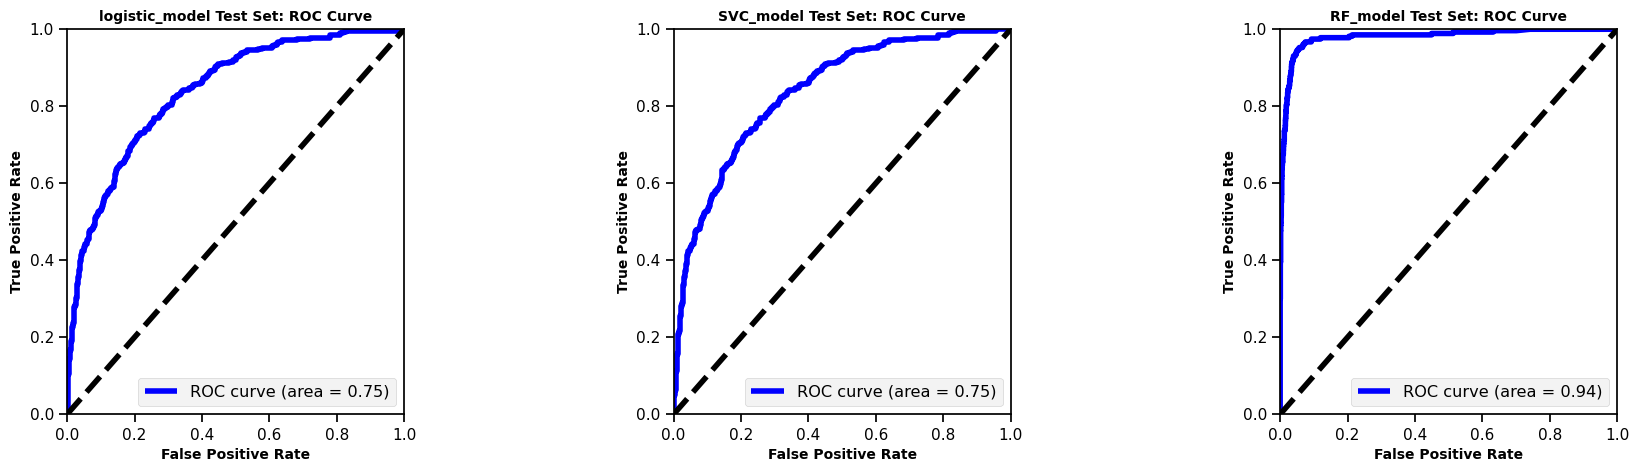

In [41]:
testset_df=pd.DataFrame()
indx=['logistic_model', 'SVC_model', 'RF_model']

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)
fig.subplots_adjust(hspace=0.8, wspace=0.8)

metric_lst=[]

for idx, clsfr in enumerate([lc_grid_srch, svc_mdl_pipeline, rf_grid_srch]):
    
    y_pred=clsfr.predict(X_test)
    
    metric_lst.append(round(accuracy_score(y_test, y_pred),2))
    metric_lst.append(round(precision_score(y_test, y_pred),2))
    metric_lst.append(round(recall_score(y_test, y_pred),2))    
    metric_lst.append(round(f1_score(y_test, y_pred),2))
    
    pred_cls1=clsfr.predict_proba(X_test)[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, pred_cls1)
    auc_score=roc_auc_score(y_test, y_pred)

    plt.style.use('fivethirtyeight')
    ax[idx].plot(fpr, tpr, label='ROC curve (area = %0.2f)' %auc_score)
    ax[idx].plot([0,1], [0,1], 'k--')
    ax[idx].set_xlim([0.0, 1.0])
    ax[idx].set_ylim([0.0, 1.0])
    ax[idx].set_xlabel('False Positive Rate', weight='bold', size=10)
    ax[idx].set_ylabel('True Positive Rate', weight='bold', size=10)
    ax[idx].set_title(indx[idx]+' Test Set: ROC Curve', fontsize=10, fontweight='bold')
    ax[idx].legend(loc="lower right", fontsize='small')

plt.show()
testset_df['Test Data Set']=metric_lst    

iterables = [indx, ['Accuracy', 'Precision', 'Recall', 'F1']]
array=pd.MultiIndex.from_product(iterables, names=['model', 'metrics'])

#create dataframe of the various models' test evaluation measures
testset_df.index=array



In [44]:
#create dataframe of the various models' validation evaluation measures
validation_df=pd.concat([lc_mdl_df,svc_df,rf_df])

#create a dataframe comparing validation and evaluation results 
final_df=pd.concat([validation_df, testset_df], axis=1).unstack().sort_values(by=[('Test Data Set','F1')], 
                                                                     ascending=False)

In [45]:
final_df

Validation Set                        Test Data Set        \
metrics              Accuracy    F1 Precision Recall      Accuracy    F1   
model                                                                      
RF_model                 0.95  0.80      0.74   0.88          0.96  0.83   
SVC_model                0.75  0.43      0.29   0.82          0.75  0.41   
logistic_model           0.76  0.43      0.30   0.80          0.76  0.41   

                                 
metrics        Precision Recall  
model                            
RF_model            0.76   0.92  
SVC_model           0.28   0.76  
logistic_model      0.29   0.74

With all models' hyperparameters tuned and metrics evaluated on the validation datasets (subset of the training data), predictions on the test data are made to see how well the models perform on unseen data.  The support vector machine pipeline is reinstantiated to include class probabilities in predicted output, which will allow its ROC curve to be derived and displayed for comparison with the other models' curves.

As shown in the above table, random forest model performs best in both the training and test datasets.  It evaluates even better on the test data with a 0.92 recall score.  The random forest model is extremely powerful with its ROC curve situated high in the upper left quadrant of the graph (right most graph).  When we compare the logistic and SVC models' evaluation measures, ROC curves and their 'area under curve' there is very little to distinguish one from the other on the test dataset.  There is a slight degradation in their evaluation measures  when comparing the test set results against the validation set. 

## V: Conclusion

Three classification models were built by tuning hyperparameters thru grid search or randomized search and performing 10 fold cross validation on the training dataset.  The parameters of the fitted models returning the highest f1 score were used to estimate the target values and class probabilities on the test dataset.  The random forest model performed the best in both the training and test datasets, and should generalize well on unseen data.  

In contrast, the logistic regression and SVC model need to further recalibrated.  Logistic regression may not be best suited for this problem set since the attributes might not have a linear relationship with the outcome classes. It would be interesting to see if using kPCA, which handles non-linear class separability, has benefits in model performance versus using LDA.  Another potential area to explore is the resampling process.  The logistic and SVC model have a high false positive rate, as evidenced by their low precision scores.  The AYASYN resampler was used to generated more positive class instances.  These models, when fit on the training data, likely could not distinguish one class from the another.